In [1]:
import datetime
current_datetime = datetime.datetime.today()
print("This .ipynb last executed at {0}".format(current_datetime))

This .ipynb last executed at 2020-05-10 11:00:14.309563


# Prepare Train set and Test set of the RSSI Data for DNN/CNN
Using 2nd measurement (20200212, <= 20 measurements at each location out of four, TST Avenue of Stars)

Reference:

(1) Wireless Indoor Localization Using Convolutional Neural Network and Gaussian Process Regression (Guolong Zhang 1, Ping Wang 2, Haibing Chen 1 and Lan Zhang)

(2) A Reproducible Analysis of RSSI Fingerprinting for Outdoor Localization Using Sigfox: Preprocessing and Hyperparameter Tuning (Grigorios G. Anagnostopoulos, Alexandros Kalousis Geneva School of Business Administration, HES-SO Geneva, Switzerland)


## Steps
1. Import all BS ID and set the default RSSI value of each BS = NaN
    > each BS ID is the feature (i.e. dimension) of the data
2. Import raw RSSI data. Clean it and prepare it for training.
3. Split up the data set into training, validation, and test set
4. Data augmentation on the training set

        ==> Scheme 2: Augmentation with the Mean and Uniform Random Numbers
        ==> paper: Data Augmentation Schemes for Deep Learning in an Indoor Positioning Application.pdf
5. Deal with empty RSSI values, 

    (1) insert 0 dBm OR ==> Wireless Indoor Localization Using Convolutional Neural Network and Gaussian Process Regression.pdf
    
    (2) insert a -200 dBm OR ==> A Reproducible Analysis of RSSI Fingerprinting for Outdoor Localization Using Sigfox: Preprocessing and Hyperparameter Tuning.pdf
    
    **(3) insert the min RSSI (e.g. -126 or -157 etc. dBm)
5. Normalize the RSSI values of all BS. Reason: make the values of the input data into [0,1] range.
    
    **(1) "min–max normalization" method ==> Wireless Indoor Localization Using Convolutional Neural Network and Gaussian Process Regression.pdf
        normalized_x = (x_i - x_min)/(x_max - x_min)
        
    (2) "threshold" ==> A Reproducible Analysis of RSSI Fingerprinting for Outdoor Localization Using Sigfox: Preprocessing and Hyperparameter Tuning.pdf
        normalized_x = (x_i - threshold)/(-x_min)
        e.g. threshold = x_min
    (3) no normalization
6. Save and Export the prepared data in .xlsx format.

## Import Libraries
Import all necessary python libraries.

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None) #Setting to display All columns of Dataframe
import seaborn as sns
from scipy import stats
from IPython.display import display, HTML

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing


Set some standard parameters
1. Print out the Keras version that we have installed. 
2. Set labels (loc1, loc2, loc3, loc4). Since we will use the list of labels multiple times, we create a constant for them (LABELS). 
    
    Location: TST, Avenue of Stars
    
    GPS(latitude,longitude) 
    
    loc1: 22.29321, 114.172877
    
    loc2: 22.293025, 114.173606
    
    loc3: 22.293381, 114.175046
    
    loc4: 22.29373, 114.175408	

## 2 import all BS ID and set the default RSSI value of each BS = NaN
each BS ID is the feature (i.e. dimension) of the data

In [3]:
def readData(file_path_2d_list,label_list):
    #1.
    #Import BS list to define the column names of the ML data list
    #=>BS ID as column names, location as labels, 
    bs_df = pd.read_excel('BS_list_2020.xlsx', index_col=0)
    #Drop that rows if the ['Latitude', 'Longitude'] columns contained NaN
    bs_df = bs_df.dropna(subset=['Latitude', 'Longitude'])
    #Add two rows for storing GPS of that location
    column_name = np.append(np.array(['device','seqNumber','location','gps','file']), bs_df['Id'].unique())
    column_name_df = pd.DataFrame(columns=column_name)
    print("Number of BS in HK: {}".format(bs_df['Id'].count()))
    
    #2.
    #Save the dataframe in list type by its location (loc1~4)
    #Also concatenate the dataframe into one
    frames = list()
    for file_path_list,label in zip(file_path_2d_list,label_list):
#         print(file_path_list)
        for filepath in file_path_list:
            print(label,">>>",filepath)
            df = pd.read_excel(filepath)
            #Add extra columns into the df
            df.insert(loc=0, column='location', value=None)
            df.insert(loc=0, column='file', value=None)
            df.loc[:,'location'] = label
            df.loc[:,'gps'] = df['DeviceGPSLat'].astype(str).str.cat(df['DeviceGPSLng'].astype(str), sep=',')
            df.loc[:,'file'] = filepath
            df.dropna(subset = ['rssi'], inplace=True) #drop that row if NaN presents in 'rssi' column
            df.sort_values(['seqNumber','station'], inplace=True)
            df.reset_index(drop=True,inplace=True)
            frames.append(df)
#         print("#data: "+str(len(frames)))
    #Concatenate different RSSI dataframe into one df
    df = pd.concat(frames,ignore_index=True,sort=False)
    #Drop unwanted columns
    df.drop(['indexOriginal','avgSnr','duplicate','lat','lng','Unnamed: 31','note','StationHowMany','WholeHTTP'],axis=1,inplace=True)
    #Move the 'device' column before 'seqNumber'
    val = df['device']
    df.drop(columns='device',inplace=True)
    col_numb = df.columns.get_loc("seqNumber")
    df.insert(loc=col_numb, column='device', value=val)
    
    #Make the content of the ML data set
    data_df_allinone = df.pivot_table(
        values='rssi',
        index=['location','gps','file','device','seqNumber','PathLossExponent','ReferenceRSSI','DeviceLLSLat','DeviceLLSLng','LocalizationError',
                                                 'nCrPathLossExponent','nCrReferenceRSSI','nCrDeviceLLSLat','nCrDeviceLLSLng','nCrLocalizationError'],
        columns='station'
    )
    #Makes the index columns i.e. ['location','gps','file','seqNumber'] back to normal columns
    data_df_allinone.reset_index(inplace=True)
    
    #3.
    #Concatenate the ML data set: column names df (from BS list) and the RSSI content df
    ml_data_df = pd.concat([column_name_df,data_df_allinone], axis=1, sort=False)
    ml_data_df = column_name_df.append(data_df_allinone,ignore_index=True, sort=False)
    return ml_data_df, df, bs_df['Id'].unique().tolist(),frames



In [4]:
#Train set - Import training data from .xlsx
train_data_filename = [['cleaned_nCr_rssi_tst_loc1_03.xlsx','cleaned_nCr_rssi_tst_loc1_04_3E81CB_20200316.xlsx','cleaned_nCr_rssi_tst_loc1_04_4171F4_20200316.xlsx','cleaned_nCr_rssi_tst_loc1_04_4190FE_20200316.xlsx'],
                       ['cleaned_nCr_rssi_tst_loc2_03.xlsx','cleaned_nCr_rssi_tst_loc2_04_3E81CB_20200316.xlsx','cleaned_nCr_rssi_tst_loc2_04_4171F4_20200316.xlsx','cleaned_nCr_rssi_tst_loc2_04_4190FE_20200316.xlsx'],
                       ['cleaned_nCr_rssi_tst_loc3_04_3E81CB_20200316.xlsx','cleaned_nCr_rssi_tst_loc3_04_4171F4_20200316.xlsx','cleaned_nCr_rssi_tst_loc3_04_4190FE_20200316.xlsx'],
                       ['cleaned_nCr_rssi_tst_loc4_04_3E81CB_20200316.xlsx','cleaned_nCr_rssi_tst_loc4_04_4171F4_20200316.xlsx','cleaned_nCr_rssi_tst_loc4_04_4190FE_20200316.xlsx']
                      ]
#Train set - The labels must have the same order with above file paths
train_label_list = ['region1',
                    'region2',
                    'region3',
                    'region4']
#Test set - Import training data from .xlsx
test_data_filename = [['cleaned_nCr_rssi_tst_loc1_02.xlsx'],
                      ['cleaned_nCr_rssi_tst_loc2_02.xlsx'],
                      ['cleaned_nCr_rssi_tst_loc3_02.xlsx'],
                      ['cleaned_nCr_rssi_tst_loc4_02.xlsx']
                     ]
#Test set - The labels must have the same order with above file paths
test_label_list = ['region1',
                   'region2',
                   'region3',
                   'region4']
#Combine two list
file_path_2d_list = train_data_filename + test_data_filename
label_list = train_label_list + test_label_list
#Read data from .xlsx
print("Importing data......")
read_data = readData(file_path_2d_list,label_list)
df_ml_data = read_data[0]
df_original = read_data[1]
bs_id_list = read_data[2]
frames = read_data[3]
df = df_ml_data['seqNumber'].sort_values()
print(df.head(1).values, df.tail(1).values)
# print(df_original['station'].unique())
# print(df_original['rssi'].sort_values(ascending=False).unique())
# print(df_original.index)
print(bs_id_list)

Importing data......
Number of BS in HK: 71
region1 >>> cleaned_nCr_rssi_tst_loc1_03.xlsx
region1 >>> cleaned_nCr_rssi_tst_loc1_04_3E81CB_20200316.xlsx
region1 >>> cleaned_nCr_rssi_tst_loc1_04_4171F4_20200316.xlsx
region1 >>> cleaned_nCr_rssi_tst_loc1_04_4190FE_20200316.xlsx
region2 >>> cleaned_nCr_rssi_tst_loc2_03.xlsx
region2 >>> cleaned_nCr_rssi_tst_loc2_04_3E81CB_20200316.xlsx
region2 >>> cleaned_nCr_rssi_tst_loc2_04_4171F4_20200316.xlsx
region2 >>> cleaned_nCr_rssi_tst_loc2_04_4190FE_20200316.xlsx
region3 >>> cleaned_nCr_rssi_tst_loc3_04_3E81CB_20200316.xlsx
region3 >>> cleaned_nCr_rssi_tst_loc3_04_4171F4_20200316.xlsx
region3 >>> cleaned_nCr_rssi_tst_loc3_04_4190FE_20200316.xlsx
region4 >>> cleaned_nCr_rssi_tst_loc4_04_3E81CB_20200316.xlsx
region4 >>> cleaned_nCr_rssi_tst_loc4_04_4171F4_20200316.xlsx
region4 >>> cleaned_nCr_rssi_tst_loc4_04_4190FE_20200316.xlsx
region1 >>> cleaned_nCr_rssi_tst_loc1_02.xlsx
region2 >>> cleaned_nCr_rssi_tst_loc2_02.xlsx
region3 >>> cleaned_nCr_rssi

In [5]:
df_ml_data = read_data[0]
df_original = read_data[1]
bs_id_list = read_data[2]
frames = read_data[3]
df_original

,file,location,Iteration,DateRecorded,TimeRecorded,device,seqNumber,station,rssi,ExpectedRSSI,DistanceBSandDevice,snr,data,time,BaseStationLat,BaseStationLng,BaseStationHeight,BaseStationRegion,SubDistrict,BaseStationX,BaseStationY,OriginGPSLat,OriginGPSLng,PathLossExponent,ReferenceRSSI,DeviceLLSLat,DeviceLLSLng,DeviceLLSX,DeviceLLSY,DeviceGPSLat,DeviceGPSLng,LocalizationError,nCrPathLossExponent,nCrReferenceRSSI,nCrDeviceLLSX,nCrDeviceLLSY,nCrDeviceLLSLat,nCrDeviceLLSLng,nCrLocalizationError,gps
0,cleaned_nCr_rssi_tst_loc1_03.xlsx,region1,1.0,2020-02-17,17:43:26,3E81CB,1292,6BFE,-123.0,-131.454949,8673.571830,6.00,01542b0406ce238800000000,1.581933e+09,22.362571,114.134226,90.0,New Territories,xxx,23228.2883,21664.5076,22.167615,113.908514,2.5,-33.0,22.316571,114.171156,27028.769508,16552.699969,22.29321,114.172877,2601.977959,3.026776,-0.705549,28318.845088,14793.709504,22.300742,114.183692,1392.521812,"22.29321,114.172877"
1,cleaned_nCr_rssi_tst_loc1_03.xlsx,region1,1.0,2020-02-17,17:43:26,3E81CB,1292,6C6B,-99.0,-128.370324,6528.493102,6.00,01542b0406ce238800000000,1.581933e+09,22.308348,114.234173,102.0,Kowloon,xxx,33513.9487,15638.9706,22.167615,113.908514,2.5,-33.0,22.316571,114.171156,27028.769508,16552.699969,22.29321,114.172877,2601.977959,3.026776,-0.705549,28318.845088,14793.709504,22.300742,114.183692,1392.521812,"22.29321,114.172877"
2,cleaned_nCr_rssi_tst_loc1_03.xlsx,region1,1.0,2020-02-17,17:43:26,3E81CB,1292,6DEB,-82.0,-117.153223,2323.426300,6.00,01542b0406ce238800000000,1.581933e+09,22.286528,114.151484,87.0,Hong Kong Island,Sheung Wan,25004.3291,13214.2206,22.167615,113.908514,2.5,-33.0,22.316571,114.171156,27028.769508,16552.699969,22.29321,114.172877,2601.977959,3.026776,-0.705549,28318.845088,14793.709504,22.300742,114.183692,1392.521812,"22.29321,114.172877"
3,cleaned_nCr_rssi_tst_loc1_03.xlsx,region1,1.0,2020-02-17,17:43:26,3E81CB,1292,6DED,-116.0,-131.938458,9068.559610,6.00,01542b0406ce238800000000,1.581933e+09,22.323885,114.254535,132.0,New Territories,xxx,35609.4251,17365.5215,22.167615,113.908514,2.5,-33.0,22.316571,114.171156,27028.769508,16552.699969,22.29321,114.172877,2601.977959,3.026776,-0.705549,28318.845088,14793.709504,22.300742,114.183692,1392.521812,"22.29321,114.172877"
4,cleaned_nCr_rssi_tst_loc1_03.xlsx,region1,1.0,2020-02-17,17:43:26,3E81CB,1292,6E12,-113.0,-121.283267,3398.839785,6.00,01542b0406ce238800000000,1.581933e+09,22.322607,114.163759,50.0,Kowloon,xxx,26267.5635,17223.5036,22.167615,113.908514,2.5,-33.0,22.316571,114.171156,27028.769508,16552.699969,22.29321,114.172877,2601.977959,3.026776,-0.705549,28318.845088,14793.709504,22.300742,114.183692,1392.521812,"22.29321,114.172877"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42597,cleaned_nCr_rssi_tst_loc4_02.xlsx,region4,11.0,2020-01-02 17:22:25.871,2020-01-02 17:22:25.871,3E81CB,1272,8112,-113.0,-127.005110,9186.545416,6.07,01542ce606ce2db000000000,1.577957e+09,22.350155,114.110168,56.0,New Territories,xxx,20752.4515,20284.7782,22.167615,113.908514,2.7,-20.0,22.316799,114.174896,27413.639991,16578.111287,22.29373,114.175408,2564.109960,2.074042,-39.045829,27696.963868,14005.935518,22.293653,114.177649,230.748934,"22.29373,114.175408"
42598,cleaned_nCr_rssi_tst_loc4_02.xlsx,region4,14.0,2020-01-02 17:22:25.871,2020-01-02 17:22:25.871,3E81CB,1272,8114,-118.0,-127.585839,9652.964345,6.00,01542ce606ce2db000000000,1.577957e+09,22.353631,114.107478,93.0,New Territories,xxx,20475.6205,20671.0491,22.167615,113.908514,2.7,-20.0,22.316799,114.174896,27413.639991,16578.111287,22.29373,114.175408,2564.109960,2.074042,-39.045829,27696.963868,14005.935518,22.293653,114.177649,230.748934,"22.29373,114.175408"
42599,cleaned_nCr_rssi_tst_loc4_02.xlsx,region4,22.0,2020-01-02 17:22:25.871,2020-01-02 17:22:25.871,3E81CB,1272,8117,-86.0,-108.921467,1965.113693,6.14,01542ce606ce2db000000000,1.577957e+09,22.286144,114.192657,83.0

In [6]:
df_ml_data.tail(5)

,device,seqNumber,location,gps,file,4FEE,57D5,57D7,57DA,6BFE,6C6B,6DEB,6DED,6E12,790C,79BF,79CD,79E3,7A05,7A06,7A0D,7A2D,7A32,7A4E,7A65,7A7F,7B21,7B3A,7C43,7C44,7C46,7C48,7C49,7C4B,7C52,7C54,7C55,7C57,7C59,7C5F,7C61,7C62,7C6B,7C6E,7C78,7C7B,7C86,7C88,7E46,7F0F,7F10,7F1F,7F27,7FFB,8010,8041,8042,8043,804A,80C5,80C7,810F,8111,8112,8114,8117,811A,8123,8125,812E,8138,8139,8141,8142,814E,8155,PathLossExponent,ReferenceRSSI,DeviceLLSLat,DeviceLLSLng,LocalizationError,nCrPathLossExponent,nCrReferenceRSSI,nCrDeviceLLSLat,nCrDeviceLLSLng,nCrLocalizationError
1331,4190FE,191,region4,"22.29373,114.175408",cleaned_nCr_rssi_tst_loc4_04_4190FE_20200316.xlsx,NaN,NaN,NaN,NaN,NaN,-85.0,-101.0,-114.0,-120.0,-97.0,-97.0,-114.0,-122.0,NaN,-116.0,NaN,NaN,NaN,-80.0,-108.0,NaN,-99.0,NaN,-89.0,NaN,NaN,NaN,NaN,-104.0,-116.0,-69.0,NaN,NaN,-125.0,NaN,NaN,NaN,-106.0,NaN,NaN,NaN,-109.0,NaN,NaN,-105.0,-97.0,-93.0,-100.0,NaN,NaN,-114.0,-90.0,-112.0,NaN,NaN,-91.0,-98.0,NaN,-104.0,NaN,-83.0,NaN,NaN,-126.0,NaN,NaN,NaN,-108.0,-115.0,NaN,NaN,2.5,-33.0,22.306539,114.183830,1666.497215,3.274376,-43.204358,22.304342,114.184021,1475.237720
1332,4190FE,192,region4,"22.29373,114.175408",cleaned_nCr_rssi_tst_loc4_04_4190FE_20200316.xlsx,NaN,NaN,NaN,NaN,-127.0,-91.0,-107.0,-111.0,-120.0,-92.0,-93.0,-117.0,-118.0,NaN,-117.0,NaN,NaN,NaN,-81.0,-106.0,NaN,-98.0,NaN,-93.0,-130.0,NaN,NaN,NaN,-105.0,-116.0,-72.0,NaN,NaN,NaN,NaN,NaN,NaN,-106.0,NaN,NaN,NaN,-103.0,NaN,NaN,-113.0,-95.0,-88.0,-95.0,NaN,NaN,-114.0,-92.0,-104.0,NaN,NaN,-87.0,-95.0,NaN,-106.0,-125.0,-86.0,NaN,-122.0,NaN,-128.0,NaN,NaN,-110.0,-117.0,-127.0,NaN,2.5,-33.0,22.315365,114.178856,2430.294772,2.053248,-45.130545,22.295913,114.183222,839.897277
1333,4190FE,193,region4,"22.29373,114.175408",cleaned_nCr_rssi_tst_loc4_04_4190FE_20200316.xlsx,NaN,NaN,NaN,NaN,-121.0,-89.0,-101.0,-111.0,-120.0,-96.0,-99.0,-115.0,NaN,NaN,-118.0,NaN,NaN,NaN,-81.0,-110.0,NaN,-98.0,NaN,-89.0,NaN,NaN,NaN,NaN,-102.0,-113.0,-68.0,NaN,NaN,NaN,NaN,NaN,NaN,-105.0,NaN,NaN,NaN,-106.0,NaN,NaN,-105.0,-97.0,-94.0,-95.0,NaN,NaN,-109.0,-90.0,-108.0,NaN,NaN,-93.0,-104.0,NaN,-104.0,-118.0,-82.0,NaN,NaN,-124.0,-131.0,NaN,NaN,-108.0,-119.0,-126.0,NaN,2.5,-33.0,22.314092,114.176476,2265.414793,3.127038,-0.579786,22.304381,114.166627,1489.099113
1334,4190FE,194,region4,"22.29373,114.175408",cleaned_nCr_rssi_tst_loc4_04_4190FE_20200316.xlsx,-124.0,NaN,NaN,NaN,-123.0,-87.0,-109.0,-112.0,-113.0,-94.0,-95.0,-114.0,-119.0,NaN,-119.0,NaN,NaN,-129.0,-81.0,-110.0,NaN,-99.0,NaN,-88.0,-128.0,NaN,NaN,NaN,NaN,-109.0,-70.0,NaN,NaN,NaN,NaN,NaN,NaN,-106.0,NaN,NaN,NaN,-104.0,NaN,NaN,-116.0,-99.0,-87.0,-95.0,NaN,NaN,-113.0,-90.0,-105.0,NaN,NaN,-88.0,-95.0,-133.0,-106.0,NaN,-85.0,NaN,-119.0,NaN,-127.0,NaN,NaN,-109.0,-117.0,-121.0,NaN,2.5,-33.0,22.316215,114.127414,5535.119163,3.122375,-3.173672,22.297188,114.126767,5020.460397
1335,4190FE,195,region4,"22.29373,114.175408",cleaned_nCr_rssi_tst_loc4_04_4190FE_20200316.xlsx,NaN,NaN,NaN,NaN,-121.0,-87.0,-101.0,-113.0,-119.0,-102.0,-101.0,-114.0,NaN,NaN,-114.0,NaN,NaN,NaN,-82.0,-111.0,NaN,-98.0,NaN,-84.0,NaN,NaN,NaN,NaN,-107.0,-112.0,-70.0,NaN,NaN,-124.0,NaN,NaN,NaN,-105.0,NaN,NaN,NaN,-107.0,NaN,NaN,-107.0,-95.0,-94.0,-99.0,NaN,NaN,-107.0,-89.0,-112.0,NaN,NaN,-90.0,-97.0,NaN,-104.0,-117.0,-85.0,NaN,-122.0,-124.0,-130.0,NaN,NaN,-115.0,-114.0,NaN,NaN,2.5,-33.0,22.314082,114.178042,2277.824369,3.092950,-3.259535,22.311968,114.170069,2099.904623


### Clean it and prepare it for training.

Before we continue, we will add one more column with the name "LocationEncoded" to the dataframe with the encoded value for each location:
    
    loc1 to loc4

This is needed since the deep neural network cannot work with non-numerical labels. With the LabelEncoder, we are able to easily to convert back to the original label text.

In [7]:
# Define column name of the label vector
LABEL = 'LocationEncoded'
# Transform the labels from String to Integer via LabelEncoder
le = preprocessing.LabelEncoder()
# Add a new column to the existing DataFrame with the encoded values
col_numb = df_ml_data.columns.get_loc("location")
val = le.fit_transform(df_ml_data['location'].values.ravel())
df_ml_data.insert(loc=col_numb+1, column=LABEL, value=val, allow_duplicates = False)
df_ml_data


,device,seqNumber,location,LocationEncoded,gps,file,4FEE,57D5,57D7,57DA,6BFE,6C6B,6DEB,6DED,6E12,790C,79BF,79CD,79E3,7A05,7A06,7A0D,7A2D,7A32,7A4E,7A65,7A7F,7B21,7B3A,7C43,7C44,7C46,7C48,7C49,7C4B,7C52,7C54,7C55,7C57,7C59,7C5F,7C61,7C62,7C6B,7C6E,7C78,7C7B,7C86,7C88,7E46,7F0F,7F10,7F1F,7F27,7FFB,8010,8041,8042,8043,804A,80C5,80C7,810F,8111,8112,8114,8117,811A,8123,8125,812E,8138,8139,8141,8142,814E,8155,PathLossExponent,ReferenceRSSI,DeviceLLSLat,DeviceLLSLng,LocalizationError,nCrPathLossExponent,nCrReferenceRSSI,nCrDeviceLLSLat,nCrDeviceLLSLng,nCrLocalizationError
0,3E81CB,1183,region1,0,"22.29321,114.172877",cleaned_nCr_rssi_tst_loc1_02.xlsx,NaN,NaN,NaN,NaN,-123.0,-91.0,-83.0,-113.0,-123.0,-103.0,-95.0,-117.0,NaN,-128.0,-120.0,NaN,NaN,NaN,-88.0,-110.0,NaN,-106.0,NaN,-91.0,NaN,NaN,NaN,NaN,-108.0,-119.0,-81.0,NaN,NaN,-116.0,NaN,NaN,NaN,-110.0,NaN,NaN,-128.0,-107.0,NaN,NaN,-106.0,-106.0,-97.0,-92.0,NaN,NaN,-88.0,-93.0,-103.0,NaN,NaN,-97.0,-106.0,NaN,NaN,-113.0,-90.0,NaN,NaN,NaN,NaN,NaN,NaN,-108.0,-121.0,NaN,NaN,2.7,-20.0,22.301837,114.182338,1366.421775,2.291546,-35.259594,22.297480,114.184145,1252.934808
1,3E81CB,1184,region1,0,"22.29321,114.172877",cleaned_nCr_rssi_tst_loc1_02.xlsx,NaN,NaN,NaN,NaN,-121.0,-96.0,-81.0,-113.0,-108.0,-100.0,-91.0,-112.0,NaN,-130.0,-114.0,NaN,NaN,-128.0,-86.0,-109.0,NaN,-101.0,NaN,-90.0,NaN,NaN,NaN,NaN,-107.0,-112.0,-81.0,NaN,NaN,-111.0,NaN,NaN,NaN,-112.0,NaN,NaN,-126.0,-103.0,NaN,NaN,-113.0,-102.0,-101.0,-92.0,NaN,NaN,-90.0,-94.0,-108.0,NaN,NaN,-101.0,-103.0,NaN,-110.0,-119.0,-89.0,NaN,NaN,NaN,NaN,NaN,NaN,-110.0,-120.0,NaN,NaN,2.7,-20.0,22.303785,114.179039,1335.322419,3.165624,-0.042455,22.299262,114.181688,1128.977358
2,3E81CB,1185,region1,0,"22.29321,114.172877",cleaned_nCr_rssi_tst_loc1_02.xlsx,NaN,NaN,NaN,NaN,NaN,-94.0,-80.0,-115.0,-116.0,-103.0,-95.0,-119.0,NaN,NaN,-123.0,NaN,NaN,NaN,-88.0,-111.0,NaN,-102.0,NaN,-90.0,NaN,NaN,NaN,NaN,-110.0,-116.0,-80.0,NaN,NaN,-114.0,NaN,NaN,NaN,-112.0,NaN,NaN,NaN,-107.0,NaN,NaN,-107.0,-112.0,-95.0,-93.0,NaN,NaN,-90.0,-93.0,-103.0,NaN,NaN,-99.0,-107.0,NaN,NaN,-114.0,-92.0,NaN,NaN,NaN,NaN,NaN,NaN,-106.0,-121.0,NaN,NaN,2.7,-20.0,22.309891,114.179184,1964.059216,3.062055,-1.312332,22.307688,114.181754,1850.203732
3,3E81CB,1186,region1,0,"22.29321,114.172877",cleaned_nCr_rssi_tst_loc1_02.xlsx,NaN,NaN,NaN,NaN,-123.0,-96.0,-78.0,-115.0,-111.0,-99.0,-97.0,-115.0,NaN,-131.0,-115.0,NaN,NaN,-126.0,-87.0,-108.0,NaN,-101.0,NaN,-89.0,NaN,NaN,NaN,NaN,-106.0,-114.0,-82.0,NaN,NaN,-109.0,NaN,NaN,NaN,-121.0,NaN,NaN,NaN,-106.0,NaN,NaN,-114.0,-99.0,-107.0,-91.0,NaN,NaN,-92.0,-99.0,-105.0,NaN,NaN,-99.0,-111.0,NaN,-112.0,-119.0,-91.0,NaN,NaN,NaN,NaN,NaN,NaN,-111.0,-124.0,NaN,NaN,2.7,-20.0,22.306061,114.178346,1535.020513,2.102119,-42.859053,22.300482,114.182042,1242.016615
4,3E81CB,1187,region1,0,"22.29321,114.172877",cleaned_nCr_rssi_tst_loc1_02.xlsx,NaN,NaN,NaN,NaN,NaN,-95.0,-83.0,-116.0,-118.0,-104.0,-94.0,-114.0,NaN,-130.0,-124.0,NaN,NaN,NaN,-86.0,-109.0,NaN,-103.0,NaN,-91.0,NaN,NaN,NaN,NaN,-117.0,-117.0,-82.0,NaN,NaN,-111.0,NaN,NaN,NaN,-109.0,NaN,NaN,NaN,-106.0,NaN,NaN,-107.0,-116.0,-96.0,-92.0,NaN,NaN,-90.0,-94.0,-106.0,NaN,NaN,-97.0,-105.0,NaN,NaN,-115.0,-89.0,NaN,NaN,NaN,NaN,NaN,NaN,-109.0,-122.0,NaN,NaN,2.7,-20.0,22.299252,114.185877,1496.876452,3.086483,-4.877514,22.300254,114.184731,1449.477427
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1331,4190FE,191,region4,3,"22.29373,114.175408",cleaned_nCr_rssi_tst_loc4_04_4190FE_20200316.xlsx,NaN,NaN,NaN,NaN,NaN,-85.0,-101.0,-114.0,-120.0,-97.0,-97.0,-114.0,-122.0,NaN,-116.0,NaN,NaN,NaN,-80.0,-108.0,NaN,-99.0,NaN,-89.0,NaN,NaN,NaN,NaN,-104.0,-116.0,-69.0,NaN,NaN,-125.0,NaN,NaN,NaN,-106.0,NaN,NaN,NaN,-109.0,NaN,NaN,-105.0,-97

### Check the distribution of the data

Total number of data collected (#rows,#col) = (1336, 87)
____________________________________________________________
location
region1    348
region2    344
region3    322
region4    322
dtype: int64


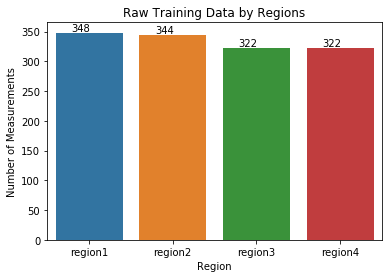

In [8]:
def plot_bar_chart_by_loc(df_plot,title=None):
    #Show how many training examples exist for each location
#     print(df_plot.sort_index())
    # ax = df_plot.nunique().plot(kind='bar', title='Training Examples by Locations')
    ax = sns.barplot(x=df_plot.index,y=df_plot)
    
    #Display values on each bar
    for p in ax.patches:
            ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()),
                        ha='center', va='bottom',
                        color= 'black'
                       )
    #Add title and axis names
    if title == None:
        title = 'Raw Training Data by Regions'
    plt.title(title)
    plt.xlabel('Region')
    plt.ylabel('Number of Measurements')
    plt.show()

print("Total number of data collected (#rows,#col) =",df_ml_data.shape)
print("____________________________________________________________")
print(df_ml_data.groupby('location').size())
plot_bar_chart_by_loc(df_ml_data.groupby('location').size())

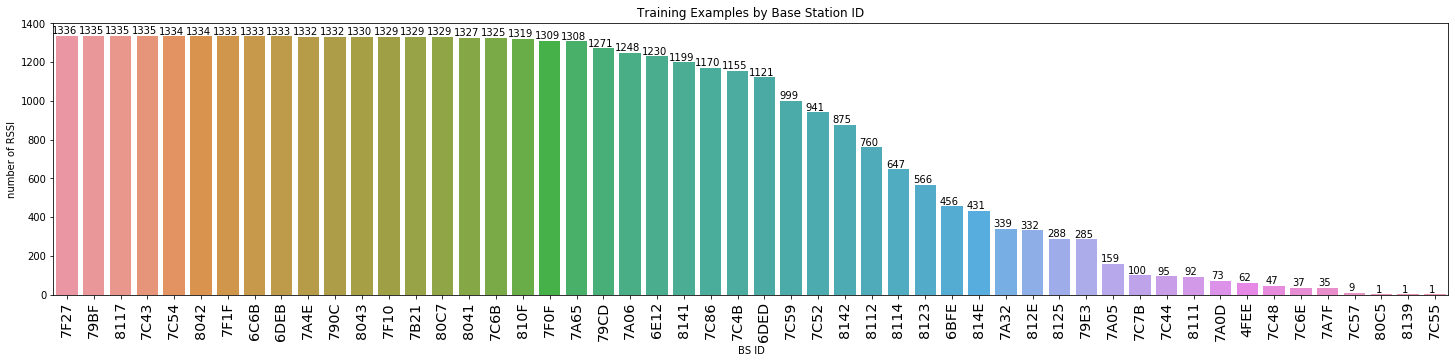

In [9]:

# Better understand how the recordings are spread across the different
# base stations which participated in the study
def plot_bar_chart_by_bs(df_plot):
    # print(df_plot)
    # ax = df_plot.plot(kind='bar', title='Training Examples by Base stations', figsize=(22,6))
    plt.figure(figsize=(25,5))
    ax = sns.barplot(x=df_plot.index, y=df_plot)#.set_title('Training Examples by Base stations')
    #Display values on each bar
    for p in ax.patches:
            ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()),
                        ha='center', va='bottom',
                        color= 'black'
                       )
    plt.xticks(
        rotation=90, 
        horizontalalignment='center',
        fontweight='light',
        fontsize='x-large'  
    )
    # Add title and axis names
    plt.title('Training Examples by Base Station ID')
    plt.xlabel('BS ID')
    plt.ylabel('number of RSSI')
    plt.show()
    
plot_bar_chart_by_bs(df_original['station'].value_counts())

## 3 Split up the data set into training, validation, and test set
It is important to separate the whole data set into a training set and a test set. Often times, you see the beginner mistake on how the data is split. However you decide to split the data, you never want information from the test set to bleed into your training set. This might be great for the overall performance of your model during training and then validation against the test set. But your model is very unlikely to generalize well for data it has not seen yet.

The idea behind splitting: We want our neural network to learn from a few persons which have been through the experiment. Next, we then want to see how well our neural network predicts the movements of persons it has not seen before.


### (didn't use) Splitting Approach 1 - Dealing with Imbalanced Data 

### Resampling the Dataset and Splitting Dataset randomly

From the bar chart above, we discover that the number of data in each location is not the same, i.e. imbalanced data.
So, resample the data to ensure the number of data in each location (class label) is the same.

In [10]:
def resampleData(dataframe):
    from sklearn.model_selection import train_test_split
    
    label_list = list(dataframe['location'].unique())
    
    #Find the smallest number of data (i.e. number of rows) under each location
    a_list = list()
    for label in label_list:
        a_list.append(dataframe[dataframe['location']==label].shape[0])
    
    min_numb_of_data = min(a_list)
    print("Least number of data in each location:",min_numb_of_data)
    
    #Resample the dataset to ensure each location contains the same number of data
    resampled_dataset = pd.DataFrame()
    for label in label_list:
#         print(label)
        df = dataframe[dataframe['location']==label]
        df = df.sample(n = min_numb_of_data)
        df.sort_values(['seqNumber'],inplace=True)
        resampled_dataset = resampled_dataset.append(df)
        resampled_dataset.reset_index(drop=True,inplace=True)
        print(label,"Train Set :", df.shape)
#         break
    return resampled_dataset

def split_train_test_data_randomly(X_data,y_label):
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X_data, y_label, test_size=0.3)#, random_state = 9)
    # Check the sample sizes
#     print("Train Set :", X_train.shape, y_train.shape)
#     print("Test Set  :", X_test.shape, y_test.shape)
    return X_train, X_test



Least number of data in each location: 322
region1 Train Set : (322, 87)
region2 Train Set : (322, 87)
region3 Train Set : (322, 87)
region4 Train Set : (322, 87)


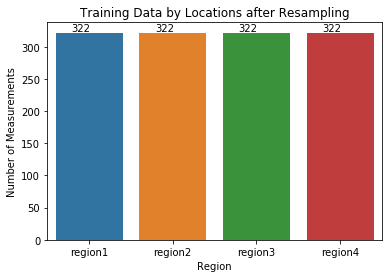

Total number of Data (#rows, #columns): (1288, 87)


In [11]:
#Resampling the data
df_resampled = resampleData(df_ml_data)
df_resampled
df_resampled['location'].value_counts()

#After resampling, show how many training examples exist for each location
plot_bar_chart_by_loc(df_resampled['location'].value_counts().sort_index(), 
                      title='Training Data by Locations after Resampling'
                     )

#Split the data into Train Set and Test Set randomly
X = df_resampled
y = df_resampled['location']
print("Total number of Data (#rows, #columns):",X.shape)
df_train_resampled, df_test_resampled = split_train_test_data_randomly(X,y)


### (didn't use) Splitting Result - Splitting Approach 1 - Resampling and Random Splitting

-----------------------------------
After splitting
Train Set (#rows, #columns) : (901, 87)


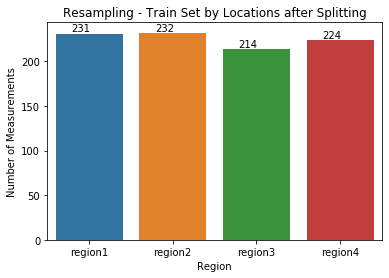

Test Set  (#rows, #columns) : (387, 87)


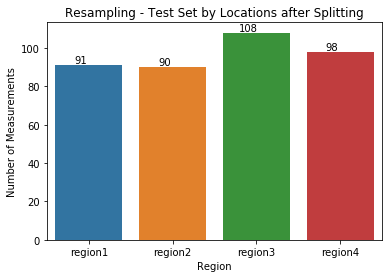

In [12]:
#After splitting
#Show how many training examples exist for each location
print("-----------------------------------")
print("After splitting")
print("Train Set (#rows, #columns) :", df_train_resampled.shape)
plot_bar_chart_by_loc(df_train_resampled['location'].value_counts().sort_index(),
                      title='Resampling - Train Set by Locations after Splitting'
                     )
print("Test Set  (#rows, #columns) :", df_test_resampled.shape)
plot_bar_chart_by_loc(df_test_resampled['location'].value_counts().sort_index(),
                      title='Resampling - Test Set by Locations after Splitting'
                     )

### Splitting Approach 2 - Just use data
Create Train-Test split from the original dataset.


In [13]:
def flatten(list_2d):
    # converting 2d list into 1d 
    # using list comprehension 
    flatten_list = [j for list_1d in list_2d for j in list_1d] 
    return flatten_list

df_train = df_ml_data[df_ml_data['file'].isin(flatten(train_data_filename))]
df_test = df_ml_data[df_ml_data['file'].isin(flatten(test_data_filename))]
df_train.reset_index(drop=True,inplace=True)
df_test.reset_index(drop=True,inplace=True)
df_test

,device,seqNumber,location,LocationEncoded,gps,file,4FEE,57D5,57D7,57DA,6BFE,6C6B,6DEB,6DED,6E12,790C,79BF,79CD,79E3,7A05,7A06,7A0D,7A2D,7A32,7A4E,7A65,7A7F,7B21,7B3A,7C43,7C44,7C46,7C48,7C49,7C4B,7C52,7C54,7C55,7C57,7C59,7C5F,7C61,7C62,7C6B,7C6E,7C78,7C7B,7C86,7C88,7E46,7F0F,7F10,7F1F,7F27,7FFB,8010,8041,8042,8043,804A,80C5,80C7,810F,8111,8112,8114,8117,811A,8123,8125,812E,8138,8139,8141,8142,814E,8155,PathLossExponent,ReferenceRSSI,DeviceLLSLat,DeviceLLSLng,LocalizationError,nCrPathLossExponent,nCrReferenceRSSI,nCrDeviceLLSLat,nCrDeviceLLSLng,nCrLocalizationError
0,3E81CB,1183,region1,0,"22.29321,114.172877",cleaned_nCr_rssi_tst_loc1_02.xlsx,NaN,NaN,NaN,NaN,-123.0,-91.0,-83.0,-113.0,-123.0,-103.0,-95.0,-117.0,NaN,-128.0,-120.0,NaN,NaN,NaN,-88.0,-110.0,NaN,-106.0,NaN,-91.0,NaN,NaN,NaN,NaN,-108.0,-119.0,-81.0,NaN,NaN,-116.0,NaN,NaN,NaN,-110.0,NaN,NaN,-128.0,-107.0,NaN,NaN,-106.0,-106.0,-97.0,-92.0,NaN,NaN,-88.0,-93.0,-103.0,NaN,NaN,-97.0,-106.0,NaN,NaN,-113.0,-90.0,NaN,NaN,NaN,NaN,NaN,NaN,-108.0,-121.0,NaN,NaN,2.7,-20.0,22.301837,114.182338,1366.421775,2.291546,-35.259594,22.297480,114.184145,1252.934808
1,3E81CB,1184,region1,0,"22.29321,114.172877",cleaned_nCr_rssi_tst_loc1_02.xlsx,NaN,NaN,NaN,NaN,-121.0,-96.0,-81.0,-113.0,-108.0,-100.0,-91.0,-112.0,NaN,-130.0,-114.0,NaN,NaN,-128.0,-86.0,-109.0,NaN,-101.0,NaN,-90.0,NaN,NaN,NaN,NaN,-107.0,-112.0,-81.0,NaN,NaN,-111.0,NaN,NaN,NaN,-112.0,NaN,NaN,-126.0,-103.0,NaN,NaN,-113.0,-102.0,-101.0,-92.0,NaN,NaN,-90.0,-94.0,-108.0,NaN,NaN,-101.0,-103.0,NaN,-110.0,-119.0,-89.0,NaN,NaN,NaN,NaN,NaN,NaN,-110.0,-120.0,NaN,NaN,2.7,-20.0,22.303785,114.179039,1335.322419,3.165624,-0.042455,22.299262,114.181688,1128.977358
2,3E81CB,1185,region1,0,"22.29321,114.172877",cleaned_nCr_rssi_tst_loc1_02.xlsx,NaN,NaN,NaN,NaN,NaN,-94.0,-80.0,-115.0,-116.0,-103.0,-95.0,-119.0,NaN,NaN,-123.0,NaN,NaN,NaN,-88.0,-111.0,NaN,-102.0,NaN,-90.0,NaN,NaN,NaN,NaN,-110.0,-116.0,-80.0,NaN,NaN,-114.0,NaN,NaN,NaN,-112.0,NaN,NaN,NaN,-107.0,NaN,NaN,-107.0,-112.0,-95.0,-93.0,NaN,NaN,-90.0,-93.0,-103.0,NaN,NaN,-99.0,-107.0,NaN,NaN,-114.0,-92.0,NaN,NaN,NaN,NaN,NaN,NaN,-106.0,-121.0,NaN,NaN,2.7,-20.0,22.309891,114.179184,1964.059216,3.062055,-1.312332,22.307688,114.181754,1850.203732
3,3E81CB,1186,region1,0,"22.29321,114.172877",cleaned_nCr_rssi_tst_loc1_02.xlsx,NaN,NaN,NaN,NaN,-123.0,-96.0,-78.0,-115.0,-111.0,-99.0,-97.0,-115.0,NaN,-131.0,-115.0,NaN,NaN,-126.0,-87.0,-108.0,NaN,-101.0,NaN,-89.0,NaN,NaN,NaN,NaN,-106.0,-114.0,-82.0,NaN,NaN,-109.0,NaN,NaN,NaN,-121.0,NaN,NaN,NaN,-106.0,NaN,NaN,-114.0,-99.0,-107.0,-91.0,NaN,NaN,-92.0,-99.0,-105.0,NaN,NaN,-99.0,-111.0,NaN,-112.0,-119.0,-91.0,NaN,NaN,NaN,NaN,NaN,NaN,-111.0,-124.0,NaN,NaN,2.7,-20.0,22.306061,114.178346,1535.020513,2.102119,-42.859053,22.300482,114.182042,1242.016615
4,3E81CB,1187,region1,0,"22.29321,114.172877",cleaned_nCr_rssi_tst_loc1_02.xlsx,NaN,NaN,NaN,NaN,NaN,-95.0,-83.0,-116.0,-118.0,-104.0,-94.0,-114.0,NaN,-130.0,-124.0,NaN,NaN,NaN,-86.0,-109.0,NaN,-103.0,NaN,-91.0,NaN,NaN,NaN,NaN,-117.0,-117.0,-82.0,NaN,NaN,-111.0,NaN,NaN,NaN,-109.0,NaN,NaN,NaN,-106.0,NaN,NaN,-107.0,-116.0,-96.0,-92.0,NaN,NaN,-90.0,-94.0,-106.0,NaN,NaN,-97.0,-105.0,NaN,NaN,-115.0,-89.0,NaN,NaN,NaN,NaN,NaN,NaN,-109.0,-122.0,NaN,NaN,2.7,-20.0,22.299252,114.185877,1496.876452,3.086483,-4.877514,22.300254,114.184731,1449.477427
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,3E81CB,1268,region4,3,"22.29373,114.175408",cleaned_nCr_rssi_tst_loc4_02.xlsx,NaN,NaN,NaN,NaN,NaN,-85.0,-99.0,-121.0,-116.0,-104.0,-92.0,-116.0,NaN,-131.0,-122.0,NaN,NaN,NaN,-82.0,-108.0,NaN,-99.0,NaN,-92.0,NaN,NaN,NaN,NaN,-116.0,-112.0,-69.0,NaN,NaN,-126.0,NaN,NaN,NaN,-114.0,NaN,NaN,NaN,-110.0,NaN,NaN,-109.0,-98.0,-91.0,-96.0,Na

In [14]:
df_test.tail(5)

,device,seqNumber,location,LocationEncoded,gps,file,4FEE,57D5,57D7,57DA,6BFE,6C6B,6DEB,6DED,6E12,790C,79BF,79CD,79E3,7A05,7A06,7A0D,7A2D,7A32,7A4E,7A65,7A7F,7B21,7B3A,7C43,7C44,7C46,7C48,7C49,7C4B,7C52,7C54,7C55,7C57,7C59,7C5F,7C61,7C62,7C6B,7C6E,7C78,7C7B,7C86,7C88,7E46,7F0F,7F10,7F1F,7F27,7FFB,8010,8041,8042,8043,804A,80C5,80C7,810F,8111,8112,8114,8117,811A,8123,8125,812E,8138,8139,8141,8142,814E,8155,PathLossExponent,ReferenceRSSI,DeviceLLSLat,DeviceLLSLng,LocalizationError,nCrPathLossExponent,nCrReferenceRSSI,nCrDeviceLLSLat,nCrDeviceLLSLng,nCrLocalizationError
85,3E81CB,1268,region4,3,"22.29373,114.175408",cleaned_nCr_rssi_tst_loc4_02.xlsx,NaN,NaN,NaN,NaN,NaN,-85.0,-99.0,-121.0,-116.0,-104.0,-92.0,-116.0,NaN,-131.0,-122.0,NaN,NaN,NaN,-82.0,-108.0,NaN,-99.0,NaN,-92.0,NaN,NaN,NaN,NaN,-116.0,-112.0,-69.0,NaN,NaN,-126.0,NaN,NaN,NaN,-114.0,NaN,NaN,NaN,-110.0,NaN,NaN,-109.0,-98.0,-91.0,-96.0,NaN,NaN,-118.0,-98.0,-104.0,NaN,NaN,-97.0,-99.0,NaN,-114.0,NaN,-83.0,NaN,NaN,NaN,NaN,NaN,NaN,-114.0,-121.0,NaN,NaN,2.7,-20.0,22.298157,114.192956,1871.666818,2.200667,-42.268976,22.303564,114.186442,1575.946513
86,3E81CB,1269,region4,3,"22.29373,114.175408",cleaned_nCr_rssi_tst_loc4_02.xlsx,NaN,NaN,NaN,NaN,NaN,-91.0,-100.0,NaN,-121.0,-102.0,-93.0,-115.0,NaN,NaN,NaN,NaN,NaN,NaN,-89.0,-116.0,NaN,-99.0,NaN,-87.0,NaN,NaN,NaN,NaN,-112.0,-117.0,-72.0,NaN,NaN,-126.0,NaN,NaN,NaN,-113.0,NaN,NaN,NaN,-110.0,NaN,NaN,-116.0,-98.0,-96.0,-92.0,NaN,NaN,-115.0,-99.0,-105.0,NaN,NaN,-96.0,-100.0,NaN,NaN,NaN,-96.0,NaN,NaN,NaN,NaN,NaN,NaN,-111.0,NaN,NaN,NaN,2.7,-20.0,22.298858,114.201246,2719.440972,3.096314,-36.428641,22.304371,114.186162,1619.544864
87,3E81CB,1270,region4,3,"22.29373,114.175408",cleaned_nCr_rssi_tst_loc4_02.xlsx,NaN,NaN,NaN,NaN,NaN,-88.0,-97.0,-121.0,-121.0,-110.0,-93.0,-114.0,NaN,NaN,NaN,NaN,NaN,NaN,-82.0,-106.0,NaN,-100.0,NaN,-89.0,NaN,NaN,NaN,NaN,-110.0,-115.0,-68.0,NaN,NaN,-126.0,NaN,NaN,NaN,-112.0,NaN,NaN,NaN,-108.0,NaN,NaN,-111.0,-98.0,-91.0,-98.0,NaN,NaN,-112.0,-94.0,-106.0,NaN,NaN,-89.0,-99.0,NaN,-114.0,-117.0,-82.0,NaN,NaN,NaN,NaN,NaN,NaN,-117.0,-122.0,NaN,NaN,2.7,-20.0,22.318665,114.176811,2774.718384,3.320810,-45.232143,22.316090,114.171212,2521.981214
88,3E81CB,1271,region4,3,"22.29373,114.175408",cleaned_nCr_rssi_tst_loc4_02.xlsx,NaN,NaN,NaN,NaN,NaN,-93.0,-97.0,-125.0,-118.0,-103.0,-96.0,-118.0,NaN,NaN,-121.0,NaN,NaN,NaN,-83.0,-111.0,NaN,-99.0,NaN,-81.0,NaN,NaN,NaN,NaN,-115.0,-123.0,-71.0,NaN,NaN,NaN,NaN,NaN,NaN,-118.0,NaN,NaN,NaN,NaN,NaN,NaN,-112.0,-101.0,-97.0,-97.0,NaN,NaN,-116.0,-100.0,-109.0,NaN,NaN,-98.0,-101.0,NaN,NaN,-114.0,-90.0,NaN,NaN,NaN,NaN,NaN,NaN,-112.0,-123.0,NaN,NaN,2.7,-20.0,22.309661,114.173709,1778.916824,3.056996,-0.865187,22.305977,114.169928,1473.135317
89,3E81CB,1272,region4,3,"22.29373,114.175408",cleaned_nCr_rssi_tst_loc4_02.xlsx,NaN,NaN,NaN,NaN,-126.0,-91.0,-97.0,-127.0,NaN,-104.0,-95.0,-115.0,NaN,NaN,-121.0,NaN,NaN,NaN,-82.0,-105.0,NaN,-103.0,NaN,-95.0,NaN,NaN,NaN,NaN,-116.0,NaN,-69.0,NaN,NaN,-127.0,NaN,NaN,NaN,-114.0,NaN,NaN,NaN,-109.0,NaN,NaN,-110.0,-100.0,-91.0,-96.0,NaN,NaN,-113.0,-100.0,-107.0,NaN,NaN,-93.0,-101.0,NaN,-113.0,-118.0,-86.0,NaN,NaN,NaN,NaN,NaN,NaN,-113.0,NaN,-123.0,NaN,2.7,-20.0,22.316799,114.174896,2564.109960,2.074042,-39.045829,22.293653,114.177649,230.748934


### Splitting Result - Splitting Approach 2 - Just use data

-----------------------------------
After splitting
Train Set (#rows, #columns) : (1246, 87)


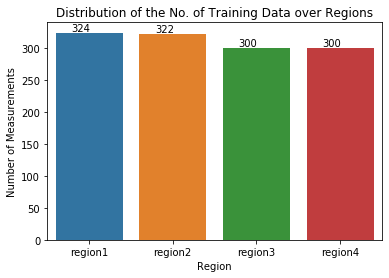

Test Set  (#rows, #columns) : (90, 87)


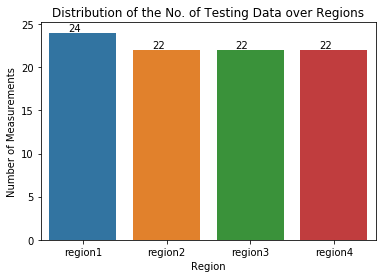

In [15]:
#After splitting
#Show how many training examples exist for each location
print("-----------------------------------")
print("After splitting")
print("Train Set (#rows, #columns) :", df_train.shape)
plot_bar_chart_by_loc(df_train['location'].value_counts().sort_index(),
                      title='Distribution of the No. of Training Data over Regions'
                     )
print("Test Set  (#rows, #columns) :", df_test.shape)
plot_bar_chart_by_loc(df_test['location'].value_counts().sort_index(),
                      title='Distribution of the No. of Testing Data over Regions'
                     )

## 4 Data Augmentation on Training set only
paper: Data Augmentation Schemes for Deep Learning in an Indoor Positioning Application.pdf

==> Scheme 2: Augmentation with the Mean and Uniform Random Numbers

Steps:
1. Find mean RSSI of each BS under each location region (=reference point) over all measurements
2. In each location region, loop each measurement (=row)
        In each measurement (=row),
        1. compare the current RSSI with mean RSSI of each BS
        2. Randomly select a value from the range between "current RSSI" and "mean RSSI" 
3. Each measurement under a location region generates N (e.g. N=60) augmented measurements


In [16]:
def dataAugmentation(dataframe):
    import math #helps check 
    
    location_list = dataframe['location'].unique().tolist()
    N = 60 #repetition number
    df_list = list()
    for location in location_list:
        df = df_train.loc[df_train['location']==location,:].copy()
        print(location)
        print('Number of measurements:',len(df))
        #Loop for individual BS (i.e. a column)
        augmented_rssi_loc_list = list()
        for bs_id in bs_id_list:
            print(bs_id,end=',')
            rssi_series = df.loc[:,bs_id]
            augmented_rssi = list()
            #Loop for each row cell in this BS (i.e. column)
            for current_rssi in rssi_series:
                #If null values, then generate null value by N times
                if math.isnan(current_rssi):
                    augmented_rssi.extend([None]*N)
                else:
#                     print(current_rssi,end=',')
                    #Calculate the mean RSSI of a BS
                    mean_rssi = round(rssi_series.mean()) 
                    #No need to randomly generate numbers if current RSSI == mean RSSI, just augment mean RSSI value
                    if current_rssi == mean_rssi:
                        augmented_rssi.extend([mean_rssi]*N)
                    #Randomly generate values between current RSSI and mean RSSI N times, if current RSSI != mean RSSI
                    elif current_rssi < mean_rssi:
                        random_rssi = list(np.random.randint(current_rssi,mean_rssi,N))
                        augmented_rssi.extend(random_rssi)
                    elif current_rssi > mean_rssi:
                        random_rssi = list(np.random.randint(mean_rssi,current_rssi,N))
                        augmented_rssi.extend(random_rssi)
            augmented_rssi_loc_list.append(augmented_rssi)
        #Under each location region, create a dataframe to save augmentation RSSI of each BS
        frames_list = list()
        for bs_aug_rssi,bs_id in zip(augmented_rssi_loc_list,bs_id_list):
            df1 = pd.DataFrame(bs_aug_rssi,columns=[bs_id])
            frames_list.append(df1)
        #Create a df to save augmented RSSI of a location region
        df2 = pd.concat(frames_list,axis=1,sort=False)
        df2['location'] = df['location'].iloc[0]
        df2['LocationEncoded'] = df['LocationEncoded'].iloc[0]
        df2['gps'] = df['gps'].iloc[0]
        df2['file'] =df2['device'] =df2['seqNumber'] =df2['PathLossExponent'] =df2['DeviceLLSLat'] \
            =df2['DeviceLLSLng'] =df2['LocalizationError'] =df2['nCrPathLossExponent'] =df2['nCrReferenceRSSI'] \
            =df2['nCrDeviceLLSLat'] =df2['nCrDeviceLLSLng'] =df2['nCrLocalizationError'] = 'augmentation'
        df_list.append(df2)
        print('\n',df2.shape)
        print('=======================')
    #Save the augmentation RSSI of all location region into a dataframe
    augmentation_only = pd.concat(df_list,sort=False,ignore_index=True)
    #Combine original dataframe and augmentation RSSI df
    df_augmented = pd.concat([dataframe,augmentation_only],sort=False,ignore_index=True)
    return df_augmented,augmentation_only

#Perform data augmentation scheme
print(df_train.shape)
df_train_augmented,augmentation_only = dataAugmentation(df_train)
print(df_train_augmented.shape)
df_train_augmented


(1246, 87)
region1
Number of measurements: 324
4FEE,57D5,57D7,57DA,6BFE,6C6B,6DEB,6DED,6E12,790C,79BF,79CD,79E3,7A05,7A06,7A0D,7A2D,7A32,7A4E,7A65,7A7F,7B21,7B3A,7C43,7C44,7C46,7C48,7C49,7C4B,7C52,7C54,7C55,7C57,7C59,7C5F,7C61,7C62,7C6B,7C6E,7C78,7C7B,7C86,7C88,7E46,7F0F,7F10,7F1F,7F27,7FFB,8010,8041,8042,8043,804A,80C5,80C7,810F,8111,8112,8114,8117,811A,8123,8125,812E,8138,8139,8141,8142,814E,8155,
 (19440, 86)
region2
Number of measurements: 322
4FEE,57D5,57D7,57DA,6BFE,6C6B,6DEB,6DED,6E12,790C,79BF,79CD,79E3,7A05,7A06,7A0D,7A2D,7A32,7A4E,7A65,7A7F,7B21,7B3A,7C43,7C44,7C46,7C48,7C49,7C4B,7C52,7C54,7C55,7C57,7C59,7C5F,7C61,7C62,7C6B,7C6E,7C78,7C7B,7C86,7C88,7E46,7F0F,7F10,7F1F,7F27,7FFB,8010,8041,8042,8043,804A,80C5,80C7,810F,8111,8112,8114,8117,811A,8123,8125,812E,8138,8139,8141,8142,814E,8155,
 (19320, 86)
region3
Number of measurements: 300
4FEE,57D5,57D7,57DA,6BFE,6C6B,6DEB,6DED,6E12,790C,79BF,79CD,79E3,7A05,7A06,7A0D,7A2D,7A32,7A4E,7A65,7A7F,7B21,7B3A,7C43,7C44,7C46,7C48,7C49,7C4

,device,seqNumber,location,LocationEncoded,gps,file,4FEE,57D5,57D7,57DA,6BFE,6C6B,6DEB,6DED,6E12,790C,79BF,79CD,79E3,7A05,7A06,7A0D,7A2D,7A32,7A4E,7A65,7A7F,7B21,7B3A,7C43,7C44,7C46,7C48,7C49,7C4B,7C52,7C54,7C55,7C57,7C59,7C5F,7C61,7C62,7C6B,7C6E,7C78,7C7B,7C86,7C88,7E46,7F0F,7F10,7F1F,7F27,7FFB,8010,8041,8042,8043,804A,80C5,80C7,810F,8111,8112,8114,8117,811A,8123,8125,812E,8138,8139,8141,8142,814E,8155,PathLossExponent,ReferenceRSSI,DeviceLLSLat,DeviceLLSLng,LocalizationError,nCrPathLossExponent,nCrReferenceRSSI,nCrDeviceLLSLat,nCrDeviceLLSLng,nCrLocalizationError
0,3E81CB,1292,region1,0,"22.29321,114.172877",cleaned_nCr_rssi_tst_loc1_03.xlsx,NaN,NaN,NaN,NaN,-123.0,-99.0,-82.0,-116.0,-113.0,-100.0,-98.0,-115.0,NaN,NaN,-114.0,NaN,NaN,NaN,-80.0,-114.0,NaN,-94.0,NaN,-90.0,NaN,NaN,NaN,NaN,-111.0,-115.0,-75.0,NaN,NaN,-113.0,NaN,NaN,NaN,-110.0,NaN,NaN,NaN,-108.0,NaN,NaN,-117.0,-102.0,-99.0,-89.0,NaN,NaN,-98.0,-95.0,-102.0,NaN,NaN,-98.0,-99.0,NaN,-109.0,-111.0,-97.0,NaN,NaN,NaN,NaN,NaN,NaN,-104.0,-120.0,-125.0,NaN,2.5,-33.0,22.3166,114.171,2601.98,3.02678,-0.705549,22.3007,114.184,1392.52
1,3E81CB,1293,region1,0,"22.29321,114.172877",cleaned_nCr_rssi_tst_loc1_03.xlsx,NaN,NaN,NaN,NaN,NaN,-98.0,-77.0,-117.0,NaN,NaN,-94.0,-113.0,NaN,NaN,-124.0,NaN,NaN,NaN,-83.0,-113.0,NaN,-101.0,NaN,-89.0,NaN,NaN,NaN,NaN,-110.0,NaN,-76.0,NaN,NaN,-115.0,NaN,NaN,NaN,-118.0,NaN,NaN,NaN,NaN,NaN,NaN,-115.0,-105.0,-99.0,-100.0,NaN,NaN,-92.0,-98.0,-104.0,NaN,NaN,-102.0,-102.0,NaN,NaN,NaN,-95.0,NaN,NaN,NaN,NaN,NaN,NaN,-108.0,-128.0,NaN,NaN,2.5,-33.0,22.2993,114.196,2452.69,3.15958,-11.7784,22.2963,114.196,2409.03
2,3E81CB,1294,region1,0,"22.29321,114.172877",cleaned_nCr_rssi_tst_loc1_03.xlsx,-123.0,NaN,NaN,NaN,-119.0,-97.0,-73.0,-117.0,-108.0,-96.0,-99.0,-110.0,NaN,-126,-113.0,NaN,NaN,-125.0,-85.0,-106.0,NaN,-101.0,NaN,-87.0,NaN,NaN,NaN,NaN,-109.0,-115.0,-76.0,NaN,NaN,-112.0,NaN,NaN,NaN,-108.0,-132,NaN,-127,-108.0,NaN,NaN,-116.0,-103.0,-96.0,-94.0,NaN,NaN,-91.0,-92.0,-106.0,NaN,NaN,-100.0,-107.0,NaN,-111.0,-111.0,-88.0,NaN,NaN,NaN,NaN,NaN,NaN,-106.0,NaN,NaN,NaN,2.5,-33.0,22.3399,114.126,7058.76,3.0931,-1.16004,22.2986,114.122,5313.97
3,3E81CB,1295,region1,0,"22.29321,114.172877",cleaned_nCr_rssi_tst_loc1_03.xlsx,NaN,NaN,NaN,NaN,NaN,-99.0,-71.0,-116.0,-117.0,-103.0,-93.0,-111.0,NaN,NaN,-129.0,NaN,NaN,NaN,-86.0,-112.0,NaN,-101.0,NaN,-91.0,NaN,NaN,NaN,NaN,-108.0,NaN,-77.0,NaN,NaN,-112.0,NaN,NaN,NaN,-115.0,NaN,NaN,NaN,-109.0,NaN,NaN,-114.0,-108.0,-96.0,-91.0,NaN,NaN,-94.0,-103.0,-102.0,NaN,NaN,-103.0,-103.0,NaN,NaN,NaN,-92.0,NaN,NaN,NaN,NaN,NaN,NaN,-108.0,NaN,NaN,NaN,2.5,-33.0,22.2995,114.196,2494.78,3.20735,-7.41232,22.2995,114.196,2448.8
4,3E81CB,1296,region1,0,"22.29321,114.172877",cleaned_nCr_rssi_tst_loc1_03.xlsx,NaN,NaN,NaN,NaN,-118.0,-94.0,-73.0,-114.0,-109.0,-99.0,-100.0,-110.0,NaN,NaN,-116.0,NaN,NaN,-127.0,-86.0,-105.0,NaN,-98.0,NaN,-82.0,NaN,NaN,NaN,NaN,-106.0,-111.0,-76.0,NaN,NaN,-111.0,NaN,NaN,NaN,-111.0,NaN,NaN,NaN,-114.0,NaN,NaN,-116.0,-101.0,-93.0,-93.0,NaN,NaN,-94.0,-101.0,-105.0,NaN,NaN,-100.0,-102.0,NaN,-111.0,-112.0,-89.0,NaN,NaN,NaN,NaN,NaN,NaN,-105.0,NaN,NaN,NaN,2.5,-33.0,22.3271,114.172,3764.45,3.00224,-1.08677,22.2989,114.187,1559.59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76001,augmentation,augmentation,region4,3,"22.29373,114.175408",augmentation,NaN,None,None,None,-124.0,-87.0,-102.0,-114.0,-119.0,-102.0,-97.0,-116.0,NaN,NaN,-118.0,NaN,None,NaN,-82.0,-111.0,NaN,-101.0,None,-85.0,NaN,None,None,None,-107.0,-115.0,-71.0,None,NaN,-126.0,None,None,None,-108.0,None,None,None,-107.0,None,None,-108.0,-96.0,-94.0,-99.0,None,None,-110.0,-92.0,-111.0,None,NaN,-92.0,-100.0,NaN,-105.0,-120.0,-86.0,None,-122.0,-125.0,-130.0,None,NaN,-114.0,-117.0

-----------------------------------
After data augmentation
Augmented Train Set (#rows, #columns) : (76006, 87)


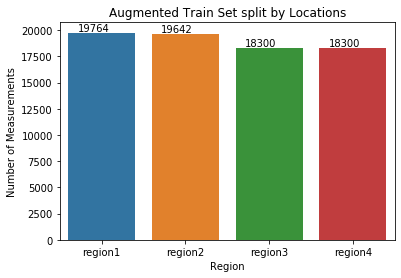

Test Set  (#rows, #columns) : (90, 87)


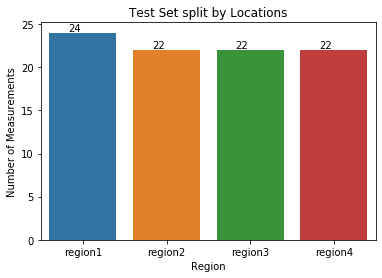

In [17]:

#After data augmentation
print("-----------------------------------")
print("After data augmentation")
print("Augmented Train Set (#rows, #columns) :", df_train_augmented.shape)
plot_bar_chart_by_loc(df_train_augmented['location'].value_counts().sort_index(),
                      title='Augmented Train Set split by Locations'
                     )

print("Test Set  (#rows, #columns) :", df_test.shape)
plot_bar_chart_by_loc(df_test['location'].value_counts().sort_index(),
                      title='Test Set split by Locations'
                     )

## 5 Deal with empty RSSI values
### (1) insert 0 dBm 
==> Wireless Indoor Localization Using Convolutional Neural Network and Gaussian Process Regression.pdf

In [18]:
insert_rssi_val = 0.0

#Insert RSSI to the 'Resampling and Random Splitting'
df_train_resampled_0_rssi = df_train_resampled.fillna(insert_rssi_val)
df_test_resampled_0_rssi = df_test_resampled.fillna(insert_rssi_val)

#Insert RSSI to the 'Just use data'
df_train_0_rssi = df_train.fillna(insert_rssi_val)
df_train_augmented_0_rssi = df_train_augmented.fillna(insert_rssi_val)
df_test_0_rssi =  df_test.fillna(insert_rssi_val)

df_train_augmented_0_rssi.tail()


,device,seqNumber,location,LocationEncoded,gps,file,4FEE,57D5,57D7,57DA,6BFE,6C6B,6DEB,6DED,6E12,790C,79BF,79CD,79E3,7A05,7A06,7A0D,7A2D,7A32,7A4E,7A65,7A7F,7B21,7B3A,7C43,7C44,7C46,7C48,7C49,7C4B,7C52,7C54,7C55,7C57,7C59,7C5F,7C61,7C62,7C6B,7C6E,7C78,7C7B,7C86,7C88,7E46,7F0F,7F10,7F1F,7F27,7FFB,8010,8041,8042,8043,804A,80C5,80C7,810F,8111,8112,8114,8117,811A,8123,8125,812E,8138,8139,8141,8142,814E,8155,PathLossExponent,ReferenceRSSI,DeviceLLSLat,DeviceLLSLng,LocalizationError,nCrPathLossExponent,nCrReferenceRSSI,nCrDeviceLLSLat,nCrDeviceLLSLng,nCrLocalizationError
76001,augmentation,augmentation,loc4,3,"22.29373,114.175408",augmentation,0.0,0.0,0.0,0.0,-123.0,-87.0,-102.0,-116.0,-119.0,-102.0,-93.0,-115.0,0.0,0.0,-117.0,0.0,0.0,0.0,-82.0,-111.0,0.0,-100.0,0.0,-85.0,0.0,0.0,0.0,0.0,-107.0,-114.0,-71.0,0.0,0.0,-126.0,0.0,0.0,0.0,-108.0,0.0,0.0,0.0,-107.0,0.0,0.0,-108.0,-97.0,-94.0,-98.0,0.0,0.0,-110.0,-90.0,-111.0,0.0,0.0,-94.0,-98.0,0.0,-106.0,-119.0,-86.0,0.0,-122.0,-126.0,-129.0,0.0,0.0,-114.0,-118.0,0.0,0.0,augmentation,0.0,augmentation,augmentation,augmentation,augmentation,augmentation,augmentation,augmentation,augmentation
76002,augmentation,augmentation,loc4,3,"22.29373,114.175408",augmentation,0.0,0.0,0.0,0.0,-124.0,-87.0,-102.0,-117.0,-119.0,-102.0,-101.0,-116.0,0.0,0.0,-119.0,0.0,0.0,0.0,-82.0,-111.0,0.0,-100.0,0.0,-85.0,0.0,0.0,0.0,0.0,-107.0,-113.0,-71.0,0.0,0.0,-125.0,0.0,0.0,0.0,-106.0,0.0,0.0,0.0,-107.0,0.0,0.0,-108.0,-97.0,-94.0,-99.0,0.0,0.0,-111.0,-92.0,-109.0,0.0,0.0,-92.0,-99.0,0.0,-107.0,-120.0,-86.0,0.0,-122.0,-125.0,-129.0,0.0,0.0,-112.0,-115.0,0.0,0.0,augmentation,0.0,augmentation,augmentation,augmentation,augmentation,augmentation,augmentation,augmentation,augmentation
76003,augmentation,augmentation,loc4,3,"22.29373,114.175408",augmentation,0.0,0.0,0.0,0.0,-123.0,-87.0,-102.0,-114.0,-119.0,-102.0,-98.0,-116.0,0.0,0.0,-119.0,0.0,0.0,0.0,-82.0,-111.0,0.0,-100.0,0.0,-85.0,0.0,0.0,0.0,0.0,-107.0,-115.0,-71.0,0.0,0.0,-125.0,0.0,0.0,0.0,-109.0,0.0,0.0,0.0,-107.0,0.0,0.0,-108.0,-97.0,-94.0,-99.0,0.0,0.0,-109.0,-93.0,-109.0,0.0,0.0,-92.0,-100.0,0.0,-107.0,-118.0,-86.0,0.0,-122.0,-126.0,-129.0,0.0,0.0,-115.0,-115.0,0.0,0.0,augmentation,0.0,augmentation,augmentation,augmentation,augmentation,augmentation,augmentation,augmentation,augmentation
76004,augmentation,augmentation,loc4,3,"22.29373,114.175408",augmentation,0.0,0.0,0.0,0.0,-125.0,-87.0,-102.0,-118.0,-119.0,-102.0,-100.0,-116.0,0.0,0.0,-116.0,0.0,0.0,0.0,-82.0,-111.0,0.0,-100.0,0.0,-85.0,0.0,0.0,0.0,0.0,-107.0,-114.0,-71.0,0.0,0.0,-125.0,0.0,0.0,0.0,-108.0,0.0,0.0,0.0,-107.0,0.0,0.0,-108.0,-96.0,-94.0,-98.0,0.0,0.0,-109.0,-92.0,-112.0,0.0,0.0,-91.0,-100.0,0.0,-106.0,-118.0,-86.0,0.0,-122.0,-127.0,-130.0,0.0,0.0,-113.0,-115.0,0.0,0.0,augmentation,0.0,augmentation,augmentation,augmentation,augmentation,augmentation,augmentation,augmentation,augmentation
76005,augmentation,augmentation,loc4,3,"22.29373,114.175408",augmentation,0.0,0.0,0.0,0.0,-125.0,-87.0,-102.0,-118.0,-119.0,-102.0,-94.0,-116.0,0.0,0.0,-115.0,0.0,0.0,0.0,-82.0,-111.0,0.0,-100.0,0.0,-85.0,0.0,0.0,0.0,0.0,-107.0,-113.0,-71.0,0.0,0.0,-125.0,0.0,0.0,0.0,-108.0,0.0,0.0,0.0,-107.0,0.0,0.0,-108.0,-97.0,-94.0,-98.0,0.0,0.0,-110.0,-94.0,-109.0,0.0,0.0,-94.0,-98.0,0.0,-105.0,-120.0,-86.0,0.0,-122.0,-127.0,-129.0,0.0,0.0,-115.0,-117.0,0.0,0.0,augmentation,0.0,augmentation,augmentation,augmentation,augmentation,augmentation,augmentation,augmentation,augmentation


### (2) insert a -200 dBm 
==> A Reproducible Analysis of RSSI Fingerprinting for Outdoor Localization Using Sigfox: Preprocessing and Hyperparameter Tuning.pdf

In [19]:
insert_rssi_val = -200.0

#Insert RSSI to the 'Resampling and Random Splitting'
df_train_resampled_neg_200_rssi = df_train_resampled.fillna(insert_rssi_val)
df_test_resampled_neg_200_rssi =  df_test_resampled.fillna(insert_rssi_val)

#Insert RSSI to the 'Just use data'
df_train_neg_200_rssi = df_train.fillna(insert_rssi_val)
df_train_augmented_neg_200_rssi = df_train_augmented.fillna(insert_rssi_val)
df_test_neg_200_rssi =  df_test.fillna(insert_rssi_val)

df_train_augmented_neg_200_rssi.tail()


,device,seqNumber,location,LocationEncoded,gps,file,4FEE,57D5,57D7,57DA,6BFE,6C6B,6DEB,6DED,6E12,790C,79BF,79CD,79E3,7A05,7A06,7A0D,7A2D,7A32,7A4E,7A65,7A7F,7B21,7B3A,7C43,7C44,7C46,7C48,7C49,7C4B,7C52,7C54,7C55,7C57,7C59,7C5F,7C61,7C62,7C6B,7C6E,7C78,7C7B,7C86,7C88,7E46,7F0F,7F10,7F1F,7F27,7FFB,8010,8041,8042,8043,804A,80C5,80C7,810F,8111,8112,8114,8117,811A,8123,8125,812E,8138,8139,8141,8142,814E,8155,PathLossExponent,ReferenceRSSI,DeviceLLSLat,DeviceLLSLng,LocalizationError,nCrPathLossExponent,nCrReferenceRSSI,nCrDeviceLLSLat,nCrDeviceLLSLng,nCrLocalizationError
76001,augmentation,augmentation,loc4,3,"22.29373,114.175408",augmentation,-200.0,-200.0,-200.0,-200.0,-123.0,-87.0,-102.0,-116.0,-119.0,-102.0,-93.0,-115.0,-200.0,-200.0,-117.0,-200.0,-200.0,-200.0,-82.0,-111.0,-200.0,-100.0,-200.0,-85.0,-200.0,-200.0,-200.0,-200.0,-107.0,-114.0,-71.0,-200.0,-200.0,-126.0,-200.0,-200.0,-200.0,-108.0,-200.0,-200.0,-200.0,-107.0,-200.0,-200.0,-108.0,-97.0,-94.0,-98.0,-200.0,-200.0,-110.0,-90.0,-111.0,-200.0,-200.0,-94.0,-98.0,-200.0,-106.0,-119.0,-86.0,-200.0,-122.0,-126.0,-129.0,-200.0,-200.0,-114.0,-118.0,-200.0,-200.0,augmentation,-200.0,augmentation,augmentation,augmentation,augmentation,augmentation,augmentation,augmentation,augmentation
76002,augmentation,augmentation,loc4,3,"22.29373,114.175408",augmentation,-200.0,-200.0,-200.0,-200.0,-124.0,-87.0,-102.0,-117.0,-119.0,-102.0,-101.0,-116.0,-200.0,-200.0,-119.0,-200.0,-200.0,-200.0,-82.0,-111.0,-200.0,-100.0,-200.0,-85.0,-200.0,-200.0,-200.0,-200.0,-107.0,-113.0,-71.0,-200.0,-200.0,-125.0,-200.0,-200.0,-200.0,-106.0,-200.0,-200.0,-200.0,-107.0,-200.0,-200.0,-108.0,-97.0,-94.0,-99.0,-200.0,-200.0,-111.0,-92.0,-109.0,-200.0,-200.0,-92.0,-99.0,-200.0,-107.0,-120.0,-86.0,-200.0,-122.0,-125.0,-129.0,-200.0,-200.0,-112.0,-115.0,-200.0,-200.0,augmentation,-200.0,augmentation,augmentation,augmentation,augmentation,augmentation,augmentation,augmentation,augmentation
76003,augmentation,augmentation,loc4,3,"22.29373,114.175408",augmentation,-200.0,-200.0,-200.0,-200.0,-123.0,-87.0,-102.0,-114.0,-119.0,-102.0,-98.0,-116.0,-200.0,-200.0,-119.0,-200.0,-200.0,-200.0,-82.0,-111.0,-200.0,-100.0,-200.0,-85.0,-200.0,-200.0,-200.0,-200.0,-107.0,-115.0,-71.0,-200.0,-200.0,-125.0,-200.0,-200.0,-200.0,-109.0,-200.0,-200.0,-200.0,-107.0,-200.0,-200.0,-108.0,-97.0,-94.0,-99.0,-200.0,-200.0,-109.0,-93.0,-109.0,-200.0,-200.0,-92.0,-100.0,-200.0,-107.0,-118.0,-86.0,-200.0,-122.0,-126.0,-129.0,-200.0,-200.0,-115.0,-115.0,-200.0,-200.0,augmentation,-200.0,augmentation,augmentation,augmentation,augmentation,augmentation,augmentation,augmentation,augmentation
76004,augmentation,augmentation,loc4,3,"22.29373,114.175408",augmentation,-200.0,-200.0,-200.0,-200.0,-125.0,-87.0,-102.0,-118.0,-119.0,-102.0,-100.0,-116.0,-200.0,-200.0,-116.0,-200.0,-200.0,-200.0,-82.0,-111.0,-200.0,-100.0,-200.0,-85.0,-200.0,-200.0,-200.0,-200.0,-107.0,-114.0,-71.0,-200.0,-200.0,-125.0,-200.0,-200.0,-200.0,-108.0,-200.0,-200.0,-200.0,-107.0,-200.0,-200.0,-108.0,-96.0,-94.0,-98.0,-200.0,-200.0,-109.0,-92.0,-112.0,-200.0,-200.0,-91.0,-100.0,-200.0,-106.0,-118.0,-86.0,-200.0,-122.0,-127.0,-130.0,-200.0,-200.0,-113.0,-115.0,-200.0,-200.0,augmentation,-200.0,augmentation,augmentation,augmentation,augmentation,augmentation,augmentation,augmentation,augmentation
76005,augmentation,augmentation,loc4,3,"22.29373,114.175408",augmentation,-200.0,-200.0,-200.0,-200.0,-125.0,-87.0,-102.0,-118.0,-119.0,-102.0,-94.0,-116.0,-200.0,-200.0,-115.0,-200.0,-200.0,-200.0,-82.0,-111.0,-200.0,-100.0,-200.0,-85.0,-200.0,-200.0,-200.0,-200.0,-107.0,-113.0,-71.0,-200.0,-200.0,-125.0,-200.0,-200.0,-200.0,-108.0,-200.0,-200.0,-200.0,-107.0,-200.0,-200.0,-108.0,-97.0,-94.0,-98.0,-200.0,-200.0,-110.0,-94.0,-109.0,-200.0,-200.0,-94.0,-98.0,-200.0,-105.0,-120.0,-86.0,-200.0,-122.0,-127.0,-129.0,-200.0,-200.0,-115.0,-117.0,-200.0,-200.0,augmentation,-200.0,augmentation,augmentation,augmentation,augmentation,augmentation,augmentation,augmentation,augmentation


### **(3) insert the min RSSI (e.g. -157 etc. dBm)
==> Wireless Indoor Localization Using Convolutional Neural Network and Gaussian Process Regression.pdf

In [20]:

print("min RSSI:")
#'Resampling and Random Splitting'
##Find the min RSSI in train set and insert it to NaN cell
df = df_train_resampled
insert_rssi_val = df[bs_id_list].min().min() #First .min() finds the minimum RSSI on every col
                                            #Second .min() finds the minimum RSSI along row
df_train_resampled_min_rssi = df.fillna(insert_rssi_val)
# print(list(df[bs_id_list].max()))
print("train_resampled:",insert_rssi_val)
##Find the min RSSI in test set and insert it to NaN cell
df = df_test_resampled
insert_rssi_val = df[bs_id_list].min().min()
df_test_resampled_min_rssi = df.fillna(insert_rssi_val)
print("test_resampled:",insert_rssi_val)


#'Just use data'
##Find the min RSSI in train set and insert it to NaN cell
df = df_train.copy()
insert_rssi_val = df[bs_id_list].min().min() #First .min() finds the minimum RSSI on every col
                                            #Second .min() finds the minimum RSSI along row
df_train_min_rssi = df.fillna(insert_rssi_val)
df = df_train_augmented.copy()
df_train_augmented_min_rssi = df.fillna(insert_rssi_val)
# print(list(df[bs_id_list].max()))
print("train:",insert_rssi_val)
##Find the min RSSI in test set and insert it to NaN cell
df = df_test.copy()
insert_rssi_val = df[bs_id_list].min().min()
df_test_min_rssi = df.fillna(insert_rssi_val)
print("test:",insert_rssi_val)

#Test
df_train_augmented_min_rssi.tail()


min RSSI:
train_resampled: -136.0
test_resampled: -136.0
train: -136.0
test: -135.0


,device,seqNumber,location,LocationEncoded,gps,file,4FEE,57D5,57D7,57DA,6BFE,6C6B,6DEB,6DED,6E12,790C,79BF,79CD,79E3,7A05,7A06,7A0D,7A2D,7A32,7A4E,7A65,7A7F,7B21,7B3A,7C43,7C44,7C46,7C48,7C49,7C4B,7C52,7C54,7C55,7C57,7C59,7C5F,7C61,7C62,7C6B,7C6E,7C78,7C7B,7C86,7C88,7E46,7F0F,7F10,7F1F,7F27,7FFB,8010,8041,8042,8043,804A,80C5,80C7,810F,8111,8112,8114,8117,811A,8123,8125,812E,8138,8139,8141,8142,814E,8155,PathLossExponent,ReferenceRSSI,DeviceLLSLat,DeviceLLSLng,LocalizationError,nCrPathLossExponent,nCrReferenceRSSI,nCrDeviceLLSLat,nCrDeviceLLSLng,nCrLocalizationError
76001,augmentation,augmentation,loc4,3,"22.29373,114.175408",augmentation,-136.0,-136.0,-136.0,-136.0,-123.0,-87.0,-102.0,-116.0,-119.0,-102.0,-93.0,-115.0,-136.0,-136.0,-117.0,-136.0,-136.0,-136.0,-82.0,-111.0,-136.0,-100.0,-136.0,-85.0,-136.0,-136.0,-136.0,-136.0,-107.0,-114.0,-71.0,-136.0,-136.0,-126.0,-136.0,-136.0,-136.0,-108.0,-136.0,-136.0,-136.0,-107.0,-136.0,-136.0,-108.0,-97.0,-94.0,-98.0,-136.0,-136.0,-110.0,-90.0,-111.0,-136.0,-136.0,-94.0,-98.0,-136.0,-106.0,-119.0,-86.0,-136.0,-122.0,-126.0,-129.0,-136.0,-136.0,-114.0,-118.0,-136.0,-136.0,augmentation,-136.0,augmentation,augmentation,augmentation,augmentation,augmentation,augmentation,augmentation,augmentation
76002,augmentation,augmentation,loc4,3,"22.29373,114.175408",augmentation,-136.0,-136.0,-136.0,-136.0,-124.0,-87.0,-102.0,-117.0,-119.0,-102.0,-101.0,-116.0,-136.0,-136.0,-119.0,-136.0,-136.0,-136.0,-82.0,-111.0,-136.0,-100.0,-136.0,-85.0,-136.0,-136.0,-136.0,-136.0,-107.0,-113.0,-71.0,-136.0,-136.0,-125.0,-136.0,-136.0,-136.0,-106.0,-136.0,-136.0,-136.0,-107.0,-136.0,-136.0,-108.0,-97.0,-94.0,-99.0,-136.0,-136.0,-111.0,-92.0,-109.0,-136.0,-136.0,-92.0,-99.0,-136.0,-107.0,-120.0,-86.0,-136.0,-122.0,-125.0,-129.0,-136.0,-136.0,-112.0,-115.0,-136.0,-136.0,augmentation,-136.0,augmentation,augmentation,augmentation,augmentation,augmentation,augmentation,augmentation,augmentation
76003,augmentation,augmentation,loc4,3,"22.29373,114.175408",augmentation,-136.0,-136.0,-136.0,-136.0,-123.0,-87.0,-102.0,-114.0,-119.0,-102.0,-98.0,-116.0,-136.0,-136.0,-119.0,-136.0,-136.0,-136.0,-82.0,-111.0,-136.0,-100.0,-136.0,-85.0,-136.0,-136.0,-136.0,-136.0,-107.0,-115.0,-71.0,-136.0,-136.0,-125.0,-136.0,-136.0,-136.0,-109.0,-136.0,-136.0,-136.0,-107.0,-136.0,-136.0,-108.0,-97.0,-94.0,-99.0,-136.0,-136.0,-109.0,-93.0,-109.0,-136.0,-136.0,-92.0,-100.0,-136.0,-107.0,-118.0,-86.0,-136.0,-122.0,-126.0,-129.0,-136.0,-136.0,-115.0,-115.0,-136.0,-136.0,augmentation,-136.0,augmentation,augmentation,augmentation,augmentation,augmentation,augmentation,augmentation,augmentation
76004,augmentation,augmentation,loc4,3,"22.29373,114.175408",augmentation,-136.0,-136.0,-136.0,-136.0,-125.0,-87.0,-102.0,-118.0,-119.0,-102.0,-100.0,-116.0,-136.0,-136.0,-116.0,-136.0,-136.0,-136.0,-82.0,-111.0,-136.0,-100.0,-136.0,-85.0,-136.0,-136.0,-136.0,-136.0,-107.0,-114.0,-71.0,-136.0,-136.0,-125.0,-136.0,-136.0,-136.0,-108.0,-136.0,-136.0,-136.0,-107.0,-136.0,-136.0,-108.0,-96.0,-94.0,-98.0,-136.0,-136.0,-109.0,-92.0,-112.0,-136.0,-136.0,-91.0,-100.0,-136.0,-106.0,-118.0,-86.0,-136.0,-122.0,-127.0,-130.0,-136.0,-136.0,-113.0,-115.0,-136.0,-136.0,augmentation,-136.0,augmentation,augmentation,augmentation,augmentation,augmentation,augmentation,augmentation,augmentation
76005,augmentation,augmentation,loc4,3,"22.29373,114.175408",augmentation,-136.0,-136.0,-136.0,-136.0,-125.0,-87.0,-102.0,-118.0,-119.0,-102.0,-94.0,-116.0,-136.0,-136.0,-115.0,-136.0,-136.0,-136.0,-82.0,-111.0,-136.0,-100.0,-136.0,-85.0,-136.0,-136.0,-136.0,-136.0,-107.0,-113.0,-71.0,-136.0,-136.0,-125.0,-136.0,-136.0,-136.0,-108.0,-136.0,-136.0,-136.0,-107.0,-136.0,-136.0,-108.0,-97.0,-94.0,-98.0,-136.0,-136.0,-110.0,-94.0,-109.0,-136.0,-136.0,-94.0,-98.0,-136.0,-105.0,-120.0,-86.0,-136.0,-122.0,-127.0,-129.0,-136.0,-136.0,-115.0,-117.0,-136.0,-136.0,augmentation,-136.0,augmentation,augmentation,augmentation,augmentation,augmentation,augmentation,augmentation,augmentation


## 6 Normalize the RSSI values of all BS. 
Reason: make the values of the input data into [0,1] range.
    
**(1) "min–max normalization" method ==> Wireless Indoor Localization Using Convolutional Neural Network and Gaussian Process Regression
        
        normalized_x = (x_i - x_min)/(x_max - x_min)
        
(2) "threshold" ==> A Reproducible Analysis of RSSI Fingerprinting for Outdoor Localization Using Sigfox: Preprocessing and Hyperparameter Tuning 
        
        normalized_x = (x_i - threshold)/(-x_min)
        e.g. threshold = x_min
        
(3) no normalization


In [20]:

# Normalize features for training data set (values between 0 and 1)
def normalizing_MinMax(dataframe):
    df = dataframe[bs_id_list]
    min_rssi = df.min().min() #First .min() finds the minimum RSSI on every col
                              #Second .min() finds the minimum RSSI along row
    max_rssi = df.max().max()
    df = (df-min_rssi) / (max_rssi-min_rssi)
    print("max RSSI: ",max_rssi)
    print("min RSSI: ",min_rssi)
    return df


Resampling and Random Splitting 

    df_train_resampled_0_rssi
    df_test_resampled_0_rssi
    df_train_resampled_neg_200_rssi
    df_test_resampled_neg_200_rssi
    df_train_resampled_min_rssi
    df_test_resampled_min_rssi

In [21]:

print("=== Resampling and Random Splitting ==============")
print("=== 0 dBm inserted")
print("> Train set",)
df1 = normalizing_MinMax(df_train_resampled_0_rssi)
df_train_resampled_0_rssi.update(df1)
print("> Test set")
df2 = normalizing_MinMax(df_test_resampled_0_rssi)
df_test_resampled_0_rssi.update(df2)

print("=== -200 dBm inserted")
print("> Train set")
df1 = normalizing_MinMax(df_train_resampled_neg_200_rssi)
df_train_resampled_neg_200_rssi.update(df1)
print("> Test set")
df2 = normalizing_MinMax(df_test_resampled_neg_200_rssi)
df_test_resampled_neg_200_rssi.update(df2)

print("=== min RSSI inserted ")
print("> Train set")
df1 = normalizing_MinMax(df_train_resampled_min_rssi)
df_train_resampled_min_rssi.update(df1)
print("> Test set")
df2 = normalizing_MinMax(df_test_resampled_min_rssi)
df_test_resampled_min_rssi.update(df2)

df_train_resampled_min_rssi.head()


=== Resampling and Random Splitting ==============
=== 0 dBm inserted
> Train set
max RSSI:  0.0
min RSSI:  -136.0
> Test set
max RSSI:  0.0
min RSSI:  -136.0
=== -200 dBm inserted
> Train set
max RSSI:  -66.0
min RSSI:  -200.0
> Test set
max RSSI:  -66.0
min RSSI:  -200.0
=== min RSSI inserted 
> Train set
max RSSI:  -66.0
min RSSI:  -136.0
> Test set
max RSSI:  -66.0
min RSSI:  -136.0


,device,seqNumber,location,LocationEncoded,gps,file,4FEE,57D5,57D7,57DA,6BFE,6C6B,6DEB,6DED,6E12,790C,79BF,79CD,79E3,7A05,7A06,7A0D,7A2D,7A32,7A4E,7A65,7A7F,7B21,7B3A,7C43,7C44,7C46,7C48,7C49,7C4B,7C52,7C54,7C55,7C57,7C59,7C5F,7C61,7C62,7C6B,7C6E,7C78,7C7B,7C86,7C88,7E46,7F0F,7F10,7F1F,7F27,7FFB,8010,8041,8042,8043,804A,80C5,80C7,810F,8111,8112,8114,8117,811A,8123,8125,812E,8138,8139,8141,8142,814E,8155,PathLossExponent,ReferenceRSSI,DeviceLLSLat,DeviceLLSLng,LocalizationError,nCrPathLossExponent,nCrReferenceRSSI,nCrDeviceLLSLat,nCrDeviceLLSLng,nCrLocalizationError
650,4171F4,152,loc3,2,"22.293381,114.175046",cleaned_nCr_rssi_tst_loc3_04_4171F4_20200316.xlsx,0.157143,0.0,0.0,0.0,0.142857,0.571429,0.585714,0.185714,0.142857,0.557143,0.528571,0.314286,0.000000,0.0,0.214286,0.0,0.0,0.0,0.757143,0.342857,0.0,0.442857,0.0,0.700000,0.0,0.0,0.0,0.0,0.428571,0.000000,0.857143,0.0,0.0,0.000000,0.0,0.0,0.0,0.342857,0.0,0.0,0.0,0.371429,0.0,0.0,0.328571,0.428571,0.471429,0.514286,0.0,0.0,0.442857,0.585714,0.314286,0.0,0.0,0.542857,0.528571,0.0,0.000000,0.000000,0.514286,0.0,0.2,0.071429,0.000000,0.0,0.0,0.285714,0.000000,0.0,0.0,2.5,-33.0,22.333214,114.118199,7336.024088,2.824504,-3.094497,22.295687,114.116985,5980.588423
314,3E81CB,1832,loc1,0,"22.29321,114.172877",cleaned_nCr_rssi_tst_loc1_04_3E81CB_20200316.xlsx,0.000000,0.0,0.0,0.0,0.000000,0.400000,0.871429,0.128571,0.000000,0.500000,0.657143,0.000000,0.000000,0.0,0.257143,0.0,0.0,0.0,0.585714,0.228571,0.0,0.385714,0.0,0.628571,0.0,0.0,0.0,0.0,0.385714,0.000000,0.785714,0.0,0.0,0.000000,0.0,0.0,0.0,0.242857,0.0,0.0,0.0,0.385714,0.0,0.0,0.328571,0.400000,0.442857,0.571429,0.0,0.0,0.428571,0.585714,0.342857,0.0,0.0,0.514286,0.471429,0.0,0.357143,0.271429,0.442857,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,2.5,-33.0,22.324843,114.169372,3533.695074,3.048340,-2.302859,22.302714,114.152877,2313.328537
331,4171F4,259,loc2,1,"22.293025,114.173606",cleaned_nCr_rssi_tst_loc2_04_4171F4_20200316.xlsx,0.000000,0.0,0.0,0.0,0.000000,0.614286,0.700000,0.371429,0.314286,0.500000,0.571429,0.328571,0.000000,0.0,0.385714,0.0,0.0,0.0,0.871429,0.442857,0.0,0.542857,0.0,0.657143,0.0,0.0,0.0,0.0,0.471429,0.357143,0.742857,0.0,0.0,0.314286,0.0,0.0,0.0,0.385714,0.0,0.0,0.0,0.000000,0.0,0.0,0.285714,0.457143,0.628571,0.614286,0.0,0.0,0.542857,0.642857,0.428571,0.0,0.0,0.571429,0.471429,0.0,0.528571,0.000000,0.600000,0.0,0.2,0.000000,0.071429,0.0,0.0,0.428571,0.314286,0.0,0.0,2.5,-33.0,22.308723,114.179666,1852.570449,2.046076,-49.069430,22.308605,114.175752,1745.316235
292,3E81CB,1808,loc1,0,"22.29321,114.172877",cleaned_nCr_rssi_tst_loc1_04_3E81CB_20200316.xlsx,0.000000,0.0,0.0,0.0,0.000000,0.514286,0.928571,0.000000,0.214286,0.500000,0.671429,0.000000,0.242857,0.0,0.285714,0.0,0.0,0.0,0.528571,0.285714,0.0,0.442857,0.0,0.614286,0.0,0.0,0.0,0.0,0.442857,0.000000,0.828571,0.0,0.0,0.257143,0.0,0.0,0.0,0.300000,0.0,0.0,0.0,0.385714,0.0,0.0,0.357143,0.385714,0.485714,0.600000,0.0,0.0,0.442857,0.628571,0.357143,0.0,0.0,0.557143,0.442857,0.0,0.342857,0.000000,0.542857,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,2.5,-33.0,22.315739,114.172634,2503.650983,2.988836,-2.014575,22.297014,114.181043,940.668754
537,3E81CB,1326,loc2,1,"22.293025,114.173606",cleaned_nCr_rssi_tst_loc2_03.xlsx,0.000000,0.0,0.0,0.0,0.000000,0.728571,0.542857,0.000000,0.257143,0.514286,0.657143,0.228571,0.000000,0.0,0.271429,0.0,0.0,0.0,0.557143,0.314286,0.0,0.500000,0.0,0.728571,0.0,0.0,0.0,0.0,0.000000,0.214286,0.942857,0.0,0.0,0.000000,0.0,0.0,0.0,0.328571,0.0,0.0,0.0,0.442857,0.0,0.0,0.328571,0.457143,0.471429,0.628571,0.0,0.0,0.414286,0.671429,0.400000,0.0,0.0,0.542857,0.457143,0.0,0.000000,0.000000,0.628571,0.0,0.2,0.000000,0.000000,0.0,0.0,0.342857,0.000000,0.0,0.0,2.5,-33.0,22.301190,114.191613,2063.292873,2.047146,-36.119831,22.290433,114.176083,384.674558


Just use data
    
    df_train_0_rssi
    df_test_0_rssi
    df_train_neg_200_rssi
    df_test_neg_200_rssi
    df_train_min_rssi
    df_test_min_rssi

In [22]:

print("=== Just use data =============================")
print("=== 0 dBm inserted ==============")
print("> Train set",)
df1 = normalizing_MinMax(df_train_0_rssi)
df_train_0_rssi.update(df1)
print("> Train set (augmented)",)
df1 = normalizing_MinMax(df_train_augmented_0_rssi)
df_train_augmented_0_rssi.update(df1)
print("> Test set")
df2 = normalizing_MinMax(df_test_0_rssi)
df_test_0_rssi.update(df2)

print("=== -200 dBm inserted ============")
print("> Train set")
df1 = normalizing_MinMax(df_train_neg_200_rssi)
df_train_neg_200_rssi.update(df1)
print("> Train set (augmented)",)
df1 = normalizing_MinMax(df_train_augmented_neg_200_rssi)
df_train_augmented_neg_200_rssi.update(df1)
print("> Test set")
df2 = normalizing_MinMax(df_test_neg_200_rssi)
df_test_neg_200_rssi.update(df2)

print("=== min RSSI inserted ===========")
print("> Train set")
df1 = normalizing_MinMax(df_train_min_rssi)
df_train_min_rssi.update(df1)
print("> Train set (augmented)",)
df1 = normalizing_MinMax(df_train_augmented_min_rssi)
df_train_augmented_min_rssi.update(df1)
print("> Test set")
df2 = normalizing_MinMax(df_test_min_rssi)
df_test_min_rssi.update(df2)

df_train_augmented_min_rssi


=== Just use data =============================
=== 0 dBm inserted ==============
> Train set
max RSSI:  0.0
min RSSI:  -136.0
> Train set (augmented)
max RSSI:  0.0
min RSSI:  -136.0
> Test set
max RSSI:  0.0
min RSSI:  -135.0
=== -200 dBm inserted ============
> Train set
max RSSI:  -66.0
min RSSI:  -200.0
> Train set (augmented)
max RSSI:  -66.0
min RSSI:  -200.0
> Test set
max RSSI:  -67.0
min RSSI:  -200.0
=== min RSSI inserted ===========
> Train set
max RSSI:  -66.0
min RSSI:  -136.0
> Train set (augmented)
max RSSI:  -66.0
min RSSI:  -136.0
> Test set
max RSSI:  -67.0
min RSSI:  -135.0


,device,seqNumber,location,LocationEncoded,gps,file,4FEE,57D5,57D7,57DA,6BFE,6C6B,6DEB,6DED,6E12,790C,79BF,79CD,79E3,7A05,7A06,7A0D,7A2D,7A32,7A4E,7A65,7A7F,7B21,7B3A,7C43,7C44,7C46,7C48,7C49,7C4B,7C52,7C54,7C55,7C57,7C59,7C5F,7C61,7C62,7C6B,7C6E,7C78,7C7B,7C86,7C88,7E46,7F0F,7F10,7F1F,7F27,7FFB,8010,8041,8042,8043,804A,80C5,80C7,810F,8111,8112,8114,8117,811A,8123,8125,812E,8138,8139,8141,8142,814E,8155,PathLossExponent,ReferenceRSSI,DeviceLLSLat,DeviceLLSLng,LocalizationError,nCrPathLossExponent,nCrReferenceRSSI,nCrDeviceLLSLat,nCrDeviceLLSLng,nCrLocalizationError
0,3E81CB,1292,loc1,0,"22.29321,114.172877",cleaned_nCr_rssi_tst_loc1_03.xlsx,0.000000,0.0,0.0,0.0,0.185714,0.528571,0.771429,0.285714,0.328571,0.514286,0.542857,0.300000,0.0,0.000000,0.314286,0.0,0.0,0.000000,0.800000,0.314286,0.0,0.600000,0.0,0.657143,0.0,0.0,0.0,0.0,0.357143,0.300000,0.871429,0.0,0.0,0.328571,0.0,0.0,0.0,0.371429,0.000000,0.0,0.000000,0.400000,0.0,0.0,0.271429,0.485714,0.528571,0.671429,0.0,0.0,0.542857,0.585714,0.485714,0.0,0.0,0.542857,0.528571,0.0,0.385714,0.357143,0.557143,0.0,0.0,0.000000,0.000000,0.0,0.0,0.457143,0.228571,0.157143,0.0,2.5,-33.0,22.3166,114.171,2601.98,3.02678,-0.705549,22.3007,114.184,1392.52
1,3E81CB,1293,loc1,0,"22.29321,114.172877",cleaned_nCr_rssi_tst_loc1_03.xlsx,0.000000,0.0,0.0,0.0,0.000000,0.542857,0.842857,0.271429,0.000000,0.000000,0.600000,0.328571,0.0,0.000000,0.171429,0.0,0.0,0.000000,0.757143,0.328571,0.0,0.500000,0.0,0.671429,0.0,0.0,0.0,0.0,0.371429,0.000000,0.857143,0.0,0.0,0.300000,0.0,0.0,0.0,0.257143,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.300000,0.442857,0.528571,0.514286,0.0,0.0,0.628571,0.542857,0.457143,0.0,0.0,0.485714,0.485714,0.0,0.000000,0.000000,0.585714,0.0,0.0,0.000000,0.000000,0.0,0.0,0.400000,0.114286,0.000000,0.0,2.5,-33.0,22.2993,114.196,2452.69,3.15958,-11.7784,22.2963,114.196,2409.03
2,3E81CB,1294,loc1,0,"22.29321,114.172877",cleaned_nCr_rssi_tst_loc1_03.xlsx,0.185714,0.0,0.0,0.0,0.242857,0.557143,0.900000,0.271429,0.400000,0.571429,0.528571,0.371429,0.0,0.142857,0.328571,0.0,0.0,0.157143,0.728571,0.428571,0.0,0.500000,0.0,0.700000,0.0,0.0,0.0,0.0,0.385714,0.300000,0.857143,0.0,0.0,0.342857,0.0,0.0,0.0,0.400000,0.057143,0.0,0.128571,0.400000,0.0,0.0,0.285714,0.471429,0.571429,0.600000,0.0,0.0,0.642857,0.628571,0.428571,0.0,0.0,0.514286,0.414286,0.0,0.357143,0.357143,0.685714,0.0,0.0,0.000000,0.000000,0.0,0.0,0.428571,0.000000,0.000000,0.0,2.5,-33.0,22.3399,114.126,7058.76,3.0931,-1.16004,22.2986,114.122,5313.97
3,3E81CB,1295,loc1,0,"22.29321,114.172877",cleaned_nCr_rssi_tst_loc1_03.xlsx,0.000000,0.0,0.0,0.0,0.000000,0.528571,0.928571,0.285714,0.271429,0.471429,0.614286,0.357143,0.0,0.000000,0.100000,0.0,0.0,0.000000,0.714286,0.342857,0.0,0.500000,0.0,0.642857,0.0,0.0,0.0,0.0,0.400000,0.000000,0.842857,0.0,0.0,0.342857,0.0,0.0,0.0,0.300000,0.000000,0.0,0.000000,0.385714,0.0,0.0,0.314286,0.400000,0.571429,0.642857,0.0,0.0,0.600000,0.471429,0.485714,0.0,0.0,0.471429,0.471429,0.0,0.000000,0.000000,0.628571,0.0,0.0,0.000000,0.000000,0.0,0.0,0.400000,0.000000,0.000000,0.0,2.5,-33.0,22.2995,114.196,2494.78,3.20735,-7.41232,22.2995,114.196,2448.8
4,3E81CB,1296,loc1,0,"22.29321,114.172877",cleaned_nCr_rssi_tst_loc1_03.xlsx,0.000000,0.0,0.0,0.0,0.257143,0.600000,0.900000,0.314286,0.385714,0.528571,0.514286,0.371429,0.0,0.000000,0.285714,0.0,0.0,0.128571,0.714286,0.442857,0.0,0.542857,0.0,0.771429,0.0,0.0,0.0,0.0,0.428571,0.357143,0.857143,0.0,0.0,0.357143,0.0,0.0,0.0,0.357143,0.000000,0.0,0.000000,0.314286,0.0,0.0,0.285714,0.500000,0.614286,0.614286,0.0,0.0,0.600000,0.500000,0.442857,0.0,0.0,0.514286,0.485714,0.0,0.357143,0.342857,0.671429,0.0,0.0,0.000000,0.000000,0.0,0.0,0.442857,0.000000,0.000000,0.0,2.5,-33.0,22.3271,114.172,3764.45,3.00224,-1.08677,22.2989,114.187,1559.59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

## 7 Save and Export the prepared data in .xlsx format.


### Get the normal-format dataframe by the 'device' and 'seqNumber'

In [23]:
device_list = df_train_min_rssi['device'].tolist()
seqNumber_list = df_train_min_rssi['seqNumber'].tolist()

df = df_original[df_original['device'].isin(device_list) & df_original['seqNumber'].isin(seqNumber_list)]

### Resampling and Random Splitting
    
    df_train_resampled_0_rssi
    df_test_resampled_0_rssi
    df_train_resampled_neg_200_rssi
    df_test_resampled_neg_200_rssi
    df_train_resampled_min_rssi
    df_test_resampled_min_rssi

### Just use data
    
    df_train_0_rssi
    df_test_0_rssi
    df_train_neg_200_rssi
    df_test_neg_200_rssi
    df_train_min_rssi
    df_test_min_rssi

In [29]:
def exportDF(normalized_filename=None,original_filename=None,export_df=None):
    #Export the dataframe
    ##Normalized Data
    pd.DataFrame(export_df).to_excel(normalized_filename)
    print(normalized_filename)
#     ##Original Data
#     device_list = export_df['device'].tolist()
#     seqNumber_list = export_df['seqNumber'].tolist()
#     df = df_original.drop(columns='gps',axis=1)
#     df = df[df['device'].isin(device_list) & df['seqNumber'].isin(seqNumber_list)]
#     pd.DataFrame(df).to_excel(original_filename)
#     print(original_filename)
    pass

date = current_datetime.strftime("%Y%m%d")
time = current_datetime.strftime("%Hhr%Mmin%S")
print(date,time)

# #Resampling and Random Splitting
# df = df_train_resampled_min_rssi
# filename = '5.1_resampled_normalized_train_data_{}_{}.xlsx'.format(date,time)
# exportDF(normalized_filename = filename,
# #         original_filename = filename.replace('normalized_',''),
#          export_df = df)
# df = df_test_resampled_min_rssi
# filename = '5.1_resampled_normalized_test_data_{}_{}.xlsx'.format(date,time)
# exportDF(normalized_filename = filename,
# #         original_filename = filename.replace('normalized_',''),
#          export_df = df)


#Just use data
##Train data
df = df_train_min_rssi
filename = '5.1_normalized_train_data_{}_{}.xlsx'.format(date,time)
exportDF(normalized_filename = filename,
#          original_filename = filename.replace('normalized_',''),
         export_df = df)
##Train augmented data
df = df_train_augmented_min_rssi
filename = '5.1_normalized_train_augmented_data_{}_{}.xlsx'.format(date,time)
exportDF(normalized_filename = filename, export_df = df)
pd.DataFrame(df).to_csv(filename.replace('xlsx','csv'))

##Test data
df = df_test_min_rssi
filename = '5.1_normalized_test_data_{}_{}.xlsx'.format(date,time)
exportDF(normalized_filename = filename,
#          original_filename = filename.replace('normalized_',''),
         export_df = df)


20200417 14hr03min32
5.1_normalized_train_data_20200417_14hr03min32.xlsx
5.1_normalized_test_data_20200417_14hr03min32.xlsx


In [25]:
df = df_original.copy()
df = df.drop(columns='gps',axis=1)
df
filename = '5.1_data_allinone_{}_{}.xlsx'.format(date,time)
pd.DataFrame(df).to_excel(filename)
print(filename)

5.1_data_allinone_20200417_14hr02min13.xlsx


In [26]:
current_datetime = datetime.datetime.today()
print("This .ipynb last executed at {dt}".format(dt=current_datetime))

This .ipynb last executed at 2020-04-17 14:03:32.324364
